## Importing Packages

In [1]:
!pip install Pulp

     |████████████████████████████████| 14.2 MB 643 kB/s 


In [2]:
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pulp
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from scipy import stats
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from scipy.stats import nbinom
import datetime as dt
import math 
# Initialize seaborn (for plotting)
sns.set()

## Loading and Inspecting Data


In [3]:
#inventory
dfInventory= pd.read_csv('inventory.csv')
dfInventory

,Day,Inventory,Demand
0,1/1/2019,4660,340
1,1/2/2019,4324,336
2,1/3/2019,4147,177
3,1/4/2019,3975,172
4,1/5/2019,3462,513
...,...,...,...
1091,12/27/2021,2636,255
1092,12/28/2021,2328,308
1093,12/29/2021,1921,407
1094,12/30/2021,1592,329


In [4]:
dfInventory['Month'] = pd.to_datetime(dfInventory['Day']).dt.month_name()

In [5]:
dfInventory['Year'] = pd.to_datetime(dfInventory['Day']).dt.year

In [6]:
dfInventory

,Day,Inventory,Demand,Month,Year
0,1/1/2019,4660,340,January,2019
1,1/2/2019,4324,336,January,2019
2,1/3/2019,4147,177,January,2019
3,1/4/2019,3975,172,January,2019
4,1/5/2019,3462,513,January,2019
...,...,...,...,...,...
1091,12/27/2021,2636,255,December,2021
1092,12/28/2021,2328,308,December,2021
1093,12/29/2021,1921,407,December,2021
1094,12/30/2021,1592,329,December,2021


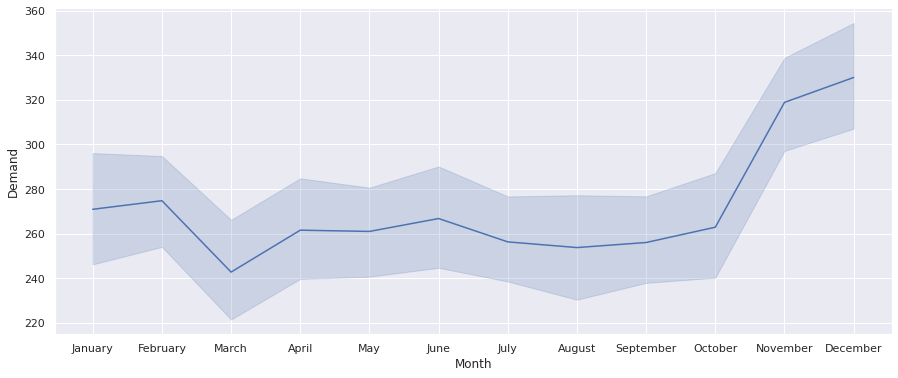

In [7]:
#plotting the monthly average demand 
plt.figure(figsize=(15,6))
sns.lineplot(x="Month", y="Demand", data=dfInventory, estimator = 'mean')
plt.show()

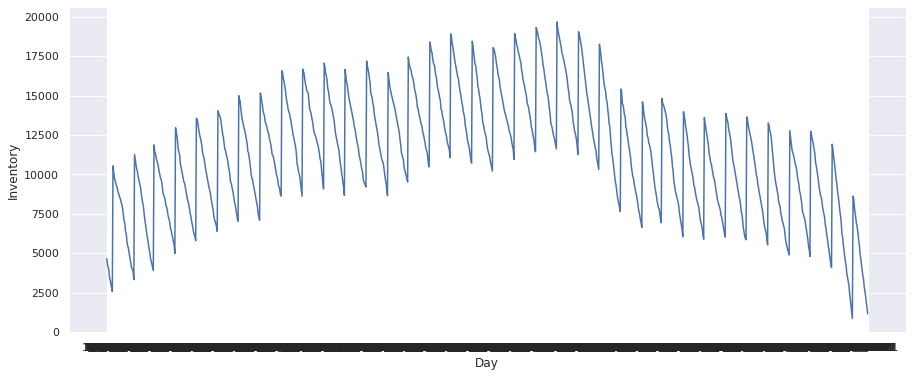

In [8]:
#plotting the inventory through time
plt.figure(figsize=(15,6))
sns.lineplot(x="Day", y="Inventory", data=dfInventory, estimator='mean')
plt.show()

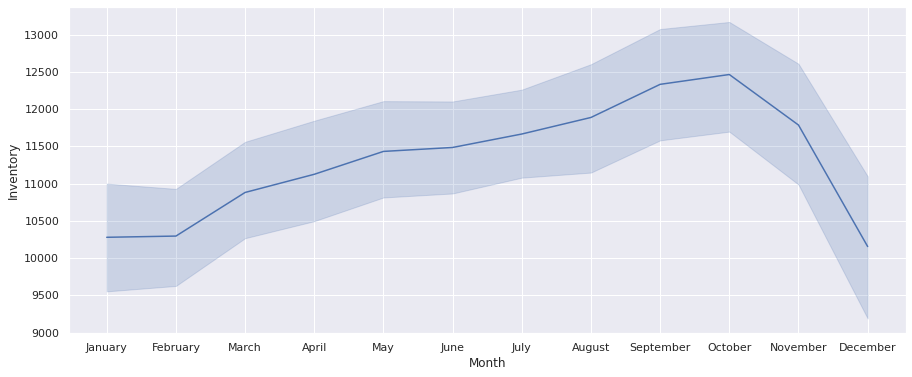

In [9]:
#plotting the average monthly inventory
plt.figure(figsize=(15,6))
sns.lineplot(x="Month", y="Inventory", data=dfInventory, estimator='mean')
plt.show()

# Old Policy Profit Analysis

In [10]:
dfInventory

,Day,Inventory,Demand,Month,Year
0,1/1/2019,4660,340,January,2019
1,1/2/2019,4324,336,January,2019
2,1/3/2019,4147,177,January,2019
3,1/4/2019,3975,172,January,2019
4,1/5/2019,3462,513,January,2019
...,...,...,...,...,...
1091,12/27/2021,2636,255,December,2021
1092,12/28/2021,2328,308,December,2021
1093,12/29/2021,1921,407,December,2021
1094,12/30/2021,1592,329,December,2021


In [11]:
#batches are produced once a month and 8150 are produced each time
yearlybatchcosts=(1200*12)+(1.50*8150*12)
yearlybatchcosts 

161100.0

In [12]:
dfInventory['StorageCost']=dfInventory['Inventory'] * 0.25
dfInventory

,Day,Inventory,Demand,Month,Year,StorageCost
0,1/1/2019,4660,340,January,2019,1165.00
1,1/2/2019,4324,336,January,2019,1081.00
2,1/3/2019,4147,177,January,2019,1036.75
3,1/4/2019,3975,172,January,2019,993.75
4,1/5/2019,3462,513,January,2019,865.50
...,...,...,...,...,...,...
1091,12/27/2021,2636,255,December,2021,659.00
1092,12/28/2021,2328,308,December,2021,582.00
1093,12/29/2021,1921,407,December,2021,480.25
1094,12/30/2021,1592,329,December,2021,398.00


In [13]:
dfInventory['Revenue']=dfInventory['Demand']*35.50
dfInventory

,Day,Inventory,Demand,Month,Year,StorageCost,Revenue
0,1/1/2019,4660,340,January,2019,1165.00,12070.0
1,1/2/2019,4324,336,January,2019,1081.00,11928.0
2,1/3/2019,4147,177,January,2019,1036.75,6283.5
3,1/4/2019,3975,172,January,2019,993.75,6106.0
4,1/5/2019,3462,513,January,2019,865.50,18211.5
...,...,...,...,...,...,...,...
1091,12/27/2021,2636,255,December,2021,659.00,9052.5
1092,12/28/2021,2328,308,December,2021,582.00,10934.0
1093,12/29/2021,1921,407,December,2021,480.25,14448.5
1094,12/30/2021,1592,329,December,2021,398.00,11679.5


In [14]:
yearlyinv=dfInventory.groupby('Year').agg('sum').reset_index()
oldpolicy=yearlyinv.copy()
oldpolicy['BatchCosts']=yearlybatchcosts
oldpolicy['Profit']=oldpolicy['Revenue']-oldpolicy['StorageCost']-oldpolicy['BatchCosts']
oldpolicy

,Year,Inventory,Demand,StorageCost,Revenue,BatchCosts,Profit
0,2019,3827485,91742,956871.25,3256841.0,161100.0,2138869.75
1,2020,5252057,98624,1313014.25,3501152.0,161100.0,2027037.75
2,2021,3327000,106856,831750.00,3793388.0,161100.0,2800538.00


In [15]:
yearmean=dfInventory.groupby('Year').agg('mean').reset_index()
yearmean

,Year,Inventory,Demand,StorageCost,Revenue
0,2019,10486.260274,251.347945,2621.565068,8922.852055
1,2020,14349.882514,269.464481,3587.470628,9565.989071
2,2021,9115.068493,292.756164,2278.767123,10392.843836


# Forecasting Demand

In [16]:
yearlydays=np.arange(1,366)

In [17]:
#create a negative binomial distribution with 365 samples for each day of the year
r = nbinom.rvs(5,0.02, size=365)
#add 30 to account for the 10/year increase in demand
r = r + 30

In [18]:
r

array([414, 237, 243, 232, 125, 371, 259, 211, 217, 221, 365, 166, 181,
       329, 260, 235, 237, 242, 455, 252, 311, 217, 317, 175, 111, 391,
       146, 262, 346, 187, 280, 271, 257, 384, 260, 404, 221, 195, 224,
       212, 159, 257, 298, 169, 163, 236, 346, 143, 250, 313, 489, 343,
       400, 234, 262, 199, 300, 425, 351, 357, 245, 218,  89, 230, 404,
       340, 199, 171, 259, 125, 435, 363, 219, 166, 202, 266, 215, 333,
       357, 242, 261, 282, 462, 313, 219, 377, 444, 312, 383, 660, 219,
       209, 330, 175, 200, 295, 156,  90, 310, 110, 167, 172, 324, 394,
       248, 215, 376, 276, 128, 261, 248, 310, 464,  80, 214, 283, 137,
       201, 123, 262, 314, 154, 251, 187, 362, 153, 147, 662, 175, 315,
       188, 293, 153, 275, 161, 335, 207, 291, 172, 192, 190, 246, 149,
       260, 418, 109, 330, 394, 416, 103, 307, 318, 252, 256, 187,  92,
       330, 565, 499, 232, 445, 226, 392, 107, 190, 358, 187, 394, 187,
       231, 317, 162, 238, 165, 276, 230, 387, 210, 199, 260, 25

In [19]:
#november and december have larger demand
r[304:]=r[304:]+70

In [20]:
r

array([414, 237, 243, 232, 125, 371, 259, 211, 217, 221, 365, 166, 181,
       329, 260, 235, 237, 242, 455, 252, 311, 217, 317, 175, 111, 391,
       146, 262, 346, 187, 280, 271, 257, 384, 260, 404, 221, 195, 224,
       212, 159, 257, 298, 169, 163, 236, 346, 143, 250, 313, 489, 343,
       400, 234, 262, 199, 300, 425, 351, 357, 245, 218,  89, 230, 404,
       340, 199, 171, 259, 125, 435, 363, 219, 166, 202, 266, 215, 333,
       357, 242, 261, 282, 462, 313, 219, 377, 444, 312, 383, 660, 219,
       209, 330, 175, 200, 295, 156,  90, 310, 110, 167, 172, 324, 394,
       248, 215, 376, 276, 128, 261, 248, 310, 464,  80, 214, 283, 137,
       201, 123, 262, 314, 154, 251, 187, 362, 153, 147, 662, 175, 315,
       188, 293, 153, 275, 161, 335, 207, 291, 172, 192, 190, 246, 149,
       260, 418, 109, 330, 394, 416, 103, 307, 318, 252, 256, 187,  92,
       330, 565, 499, 232, 445, 226, 392, 107, 190, 358, 187, 394, 187,
       231, 317, 162, 238, 165, 276, 230, 387, 210, 199, 260, 25

In [21]:
forecast=pd.DataFrame(r, columns = ['Demand'])
forecast['Day']=pd.date_range(start='1/1/2022', end='12/31/2022')

In [22]:
forecast['DayofMonth']= forecast.Day.dt.day

In [23]:
forecast

,Demand,Day,DayofMonth
0,414,2022-01-01,1
1,237,2022-01-02,2
2,243,2022-01-03,3
3,232,2022-01-04,4
4,125,2022-01-05,5
...,...,...,...
360,437,2022-12-27,27
361,416,2022-12-28,28
362,400,2022-12-29,29
363,234,2022-12-30,30


In [24]:
#to ensure accuracy of the following for loop a check is done
forecast['Inventory']=1178-forecast['Demand']
forecast
#meaning january 1 has an inv of 984

,Demand,Day,DayofMonth,Inventory
0,414,2022-01-01,1,764
1,237,2022-01-02,2,941
2,243,2022-01-03,3,935
3,232,2022-01-04,4,946
4,125,2022-01-05,5,1053
...,...,...,...,...
360,437,2022-12-27,27,741
361,416,2022-12-28,28,762
362,400,2022-12-29,29,778
363,234,2022-12-30,30,944


In [25]:
#the ending inventory of 2021 was 1178 so starting inv will be 1178
previousinv=1178
for index, row in forecast.iterrows():
    if row['DayofMonth']==10:
      forecast.loc[index, 'Inventory']= forecast.loc[index, 'Inventory']+8150
      previousinv+=8150
    forecast.loc[index, 'Served_Demand']=previousinv-row['Inventory']
    row['Inventory']=previousinv-row['Demand']
    previousinv=row['Inventory']
    forecast.loc[index, 'Inventory']=row['Inventory']
    forecast.loc[index, 'Lost Sales']=0
    if row['Inventory']<0:
      forecast.loc[index, 'Lost Sales']=row['Inventory']*-1
      forecast.loc[index, 'Inventory']=0
      previousinv=0


In [26]:
#the ending inventory of 2021 was 1178 so starting inv will be 1178
previousinv=1178
for index, row in forecast.iterrows():
    if row['DayofMonth']==10:
      forecast.loc[index, 'Inventory']= forecast.loc[index, 'Inventory']+8150
      previousinv+=8150
    forecast.loc[index, 'Served_Demand']=previousinv-row['Inventory']
    row['Inventory']=previousinv-row['Demand']
    previousinv=row['Inventory']
    forecast.loc[index, 'Inventory']=row['Inventory']
    forecast.loc[index, 'Lost Sales']=0
    if row['Inventory']<0:
      forecast.loc[index, 'Lost Sales']=row['Inventory']*-1
      forecast.loc[index, 'Inventory']=0
      previousinv=0


In [27]:
forecast

,Demand,Day,DayofMonth,Inventory,Served_Demand,Lost Sales
0,414,2022-01-01,1,764,414.0,0.0
1,237,2022-01-02,2,527,237.0,0.0
2,243,2022-01-03,3,284,243.0,0.0
3,232,2022-01-04,4,52,232.0,0.0
4,125,2022-01-05,5,0,52.0,73.0
...,...,...,...,...,...,...
360,437,2022-12-27,27,1116,437.0,0.0
361,416,2022-12-28,28,700,416.0,0.0
362,400,2022-12-29,29,300,400.0,0.0
363,234,2022-12-30,30,66,234.0,0.0


In [28]:
#number of stockouts!
print ("Number of Stockout's:",len(forecast[forecast['Served_Demand'] == 0.0]))

Number of Stockout's: 9


In [29]:
forecast.to_csv('2022forecast.csv',index=False)

In [30]:
forecast['Month'] = pd.to_datetime(forecast['Day']).dt.month_name()

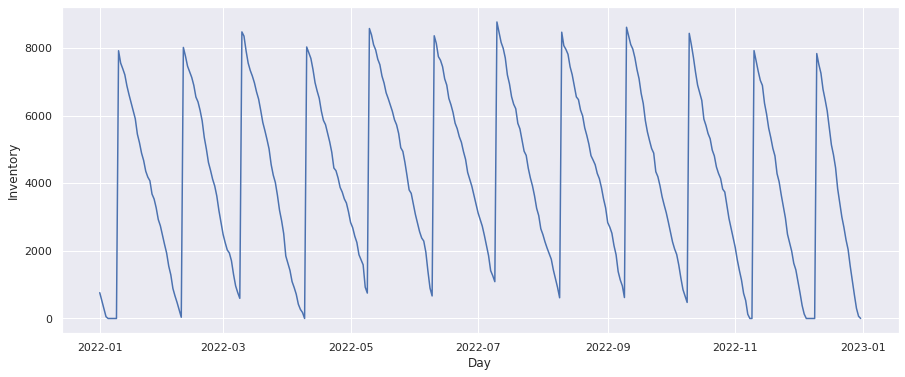

In [31]:
#plotting the daily inventory
plt.figure(figsize=(15,6))
sns.lineplot(x="Day", y="Inventory", data=forecast)
plt.show()

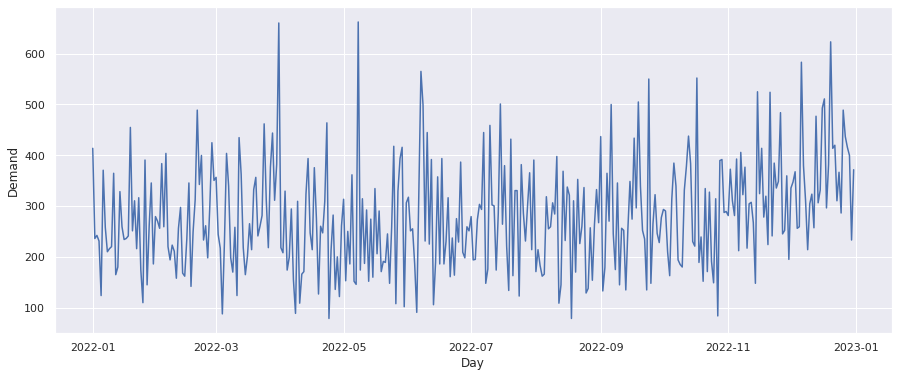

In [32]:
#plotting the daily served demand
plt.figure(figsize=(15,6))
sns.lineplot(x="Day", y="Demand", data=forecast)
plt.show()

In [33]:
forecast['Revenue']=forecast['Served_Demand']*35.50
forecast['StorageCost']=forecast['Inventory'] * 0.25
TotalRevenue=sum(forecast['Revenue'])
TotalStorageCost=sum(forecast['StorageCost'])
LostRevenue=sum(forecast['Lost Sales'])*35.50
print('Total Demand:',forecast['Demand'].sum())
print('Total Revenue:',TotalRevenue)
print('Total Storage Cost:',TotalStorageCost)
print('Total Batch Cost:',yearlybatchcosts)
print('Final Profit:',TotalRevenue-TotalStorageCost-yearlybatchcosts)
print('Total Lost Revenue Due to Stockout:',LostRevenue)
print('Total Missing Supply:',LostRevenue/35.50)

Total Demand: 102741
Total Revenue: 3513719.0
Total Storage Cost: 382099.25
Total Batch Cost: 161100.0
Final Profit: 2970519.75
Total Lost Revenue Due to Stockout: 133586.5
Total Missing Supply: 3763.0


In [34]:
forecast

,Demand,Day,DayofMonth,Inventory,Served_Demand,Lost Sales,Month,Revenue,StorageCost
0,414,2022-01-01,1,764,414.0,0.0,January,14697.0,191.00
1,237,2022-01-02,2,527,237.0,0.0,January,8413.5,131.75
2,243,2022-01-03,3,284,243.0,0.0,January,8626.5,71.00
3,232,2022-01-04,4,52,232.0,0.0,January,8236.0,13.00
4,125,2022-01-05,5,0,52.0,73.0,January,1846.0,0.00
...,...,...,...,...,...,...,...,...,...
360,437,2022-12-27,27,1116,437.0,0.0,December,15513.5,279.00
361,416,2022-12-28,28,700,416.0,0.0,December,14768.0,175.00
362,400,2022-12-29,29,300,400.0,0.0,December,14200.0,75.00
363,234,2022-12-30,30,66,234.0,0.0,December,8307.0,16.50


# EOQ Model In Previous Years

In [35]:
monthlyinv=dfInventory.groupby(['Year','Month']).agg('sum').reset_index()
monthlyinv

,Year,Month,Inventory,Demand,StorageCost,Revenue
0,2019,April,269281,7558,67320.25,268309.0
1,2019,August,354465,6869,88616.25,243849.5
2,2019,December,393760,8835,98440.00,313642.5
3,2019,February,207147,7506,51786.75,266463.0
4,2019,January,213120,7676,53280.00,272498.0
5,2019,July,340177,8078,85044.25,286769.0
6,2019,June,312708,7385,78177.00,262167.5
7,2019,March,252978,7006,63244.50,248713.0
8,2019,May,303910,7504,75977.50,266392.0
9,2019,November,396322,8415,99080.50,298732.5


In [36]:
yearmean=dfInventory.groupby(['Year','Month']).agg('mean').reset_index()

# Simple EOQ Model Analysis

#2019 EOQ Model

In [37]:
#dividing up the deamnd into two instances: prior to the holidays and the holidays (before november and after)
monthlyinv2019=monthlyinv[monthlyinv['Year']==2019]
non_hol_dem_2019=monthlyinv2019[monthlyinv2019['Month'].isin(['January','February','March','April','May','June','July','August','September','October','November'])]
hol_dem_2019=monthlyinv2019[monthlyinv2019['Month'].isin(['November','December'])]

In [38]:
#Total Yearly Demand
total_nonhol_dem_2019=non_hol_dem_2019['Demand'].sum()
total_hol_dem_2019=hol_dem_2019['Demand'].sum()
print('Total Non Holiday Demand:',total_nonhol_dem_2019)
print('Total Holiday Demand:',total_hol_dem_2019)

Total Non Holiday Demand: 82907
Total Holiday Demand: 17250


In [39]:
monthlyinv2019=monthlyinv[monthlyinv['Year']==2019]
non_hol_dem_2019=monthlyinv2019[monthlyinv2019['Month'].isin(['January','February','March','April','May','June','July','August','September','October'])]
hol_dem_2019=monthlyinv2019[monthlyinv2019['Month'].isin(['November','December'])]

In [40]:
#setup cost per order
setupcost=1200
#holding cost per unit inventory
holdingcost=0.25

In [41]:
#number of days in november and december
number_of_hol_days= 61
#number of days during the non holiday period
number_of_non_hol_days=304

In [42]:
NonHolQ2019=math.sqrt(((total_nonhol_dem_2019/number_of_non_hol_days)*2*setupcost)/holdingcost)
HolQ2019=math.sqrt(((total_hol_dem_2019/number_of_hol_days)*2*setupcost)/holdingcost)
print('2019 optimal Q on holidays:',round(HolQ2019))
print('2019 optimal Q on non holidays:',round(NonHolQ2019))

2019 optimal Q on holidays: 1648
2019 optimal Q on non holidays: 1618


In [43]:
#number of orders per season
NumOrders2019hol=total_hol_dem_2019/HolQ2019
NumOrders2019nonhol=total_nonhol_dem_2019/NonHolQ2019
print('2019 optimal number of orders during holidays:',NumOrders2019hol)
print('2019 optimal number of orders during non holidays:',NumOrders2019nonhol)

2019 optimal number of orders during holidays: 10.469449603489192
2019 optimal number of orders during non holidays: 51.23854343493122


In [44]:
monthlymean2019=yearmean[yearmean['Year']==2019]
non_hol_mean_2019=monthlymean2019[monthlymean2019['Month'].isin(['January','February','March','April','May','June','July','August','September','October'])]
hol_mean_2019=monthlymean2019[monthlymean2019['Month'].isin(['November','December'])]

In [45]:
#average demand per day
Average_Demand_nonhol_2019=non_hol_mean_2019['Demand'].mean()
Average_Demand_hol_2019=hol_mean_2019['Demand'].mean()

#reorder point calculation
LeadTime=9
ROP2019hol= Average_Demand_hol_2019*LeadTime
ROP2019nonhol= Average_Demand_nonhol_2019*LeadTime
print('ROP 2019 during holidays:',ROP2019hol)
print('ROP 2019 not during holidays:',ROP2019nonhol)

ROP 2019 during holidays: 2544.75
ROP 2019 not during holidays: 2207.3181566820276


In [46]:
EOQ_2019= dfInventory.loc[dfInventory['Year'] == 2019]
EOQ_2019= EOQ_2019.drop(['Inventory','Year','StorageCost','Revenue'],axis=1)
EOQ_2019['Inventory']=5000
EOQ_2019['Batch_Costs']=0
EOQ_2019['Revenue']=0
EOQ_2019['Storage_Costs']=0
EOQ_2019

,Day,Demand,Month,Inventory,Batch_Costs,Revenue,Storage_Costs
0,1/1/2019,340,January,5000,0,0,0
1,1/2/2019,336,January,5000,0,0,0
2,1/3/2019,177,January,5000,0,0,0
3,1/4/2019,172,January,5000,0,0,0
4,1/5/2019,513,January,5000,0,0,0
...,...,...,...,...,...,...,...
360,12/27/2019,232,December,5000,0,0,0
361,12/28/2019,227,December,5000,0,0,0
362,12/29/2019,196,December,5000,0,0,0
363,12/30/2019,409,December,5000,0,0,0


In [47]:
#starting inv was 5000
previousinv=5000
counter=0
for index, row in EOQ_2019.iterrows():
  EOQ_2019.loc[index, 'Served_Demand']=previousinv-row['Inventory']
  row['Inventory']=previousinv-row['Demand']
  previousinv=row['Inventory']
  EOQ_2019.loc[index, 'Inventory']=row['Inventory']
  EOQ_2019.loc[index, 'Lost Sales']=0


  if row['Month']!='November' and row['Month']!='December':
    if row['Inventory']<=ROP2019nonhol:
      counter+=1
      if counter>9:
        EOQ_2019.loc[index, 'Inventory']=  EOQ_2019.loc[index, 'Inventory']+round(NonHolQ2019)
        EOQ_2019.loc[index, 'Served_Demand']= EOQ_2019.loc[index, 'Served_Demand']+round(NonHolQ2019)
        EOQ_2019.loc[index, 'Batch_Costs']= 1200+(1.50*round(NonHolQ2019))

        previousinv+=round(NonHolQ2019)
        counter=0

  if row['Month']=='November' or row['Month']=='December':
    if row['Inventory']<=ROP2019hol:
      counter+=1
      if counter>9:
        EOQ_2019.loc[index, 'Inventory']= EOQ_2019.loc[index, 'Inventory']+ round(HolQ2019)
        EOQ_2019.loc[index, 'Served_Demand']= EOQ_2019.loc[index, 'Served_Demand']+round(NonHolQ2019)
        EOQ_2019.loc[index, 'Batch_Costs']= 1200+(1.50*round(HolQ2019))

        previousinv+=round(HolQ2019)
        counter=0

  if previousinv<0:
    EOQ_2019.loc[index, 'Lost Sales']=row['Inventory']*-1
    EOQ_2019.loc[index, 'Inventory']=0
    previousinv=0
  
EOQ_2019['Revenue']=EOQ_2019['Served_Demand']*35.50
EOQ_2019['Storage_Costs']=EOQ_2019['Inventory']*0.25

In [48]:
#starting inv was 5000
previousinv=5000
counter=0
for index, row in EOQ_2019.iterrows():
  EOQ_2019.loc[index, 'Served_Demand']=previousinv-row['Inventory']
  row['Inventory']=previousinv-row['Demand']
  previousinv=row['Inventory']
  EOQ_2019.loc[index, 'Inventory']=row['Inventory']
  EOQ_2019.loc[index, 'Lost Sales']=0


  if row['Month']!='November' and row['Month']!='December':
    if row['Inventory']<=ROP2019nonhol:
      counter+=1
      if counter>9:
        EOQ_2019.loc[index, 'Inventory']=  EOQ_2019.loc[index, 'Inventory']+round(NonHolQ2019)
        EOQ_2019.loc[index, 'Served_Demand']= EOQ_2019.loc[index, 'Served_Demand']+round(NonHolQ2019)
        EOQ_2019.loc[index, 'Batch_Costs']= 1200+(1.50*round(NonHolQ2019))

        previousinv+=round(NonHolQ2019)
        counter=0

  if row['Month']=='November' or row['Month']=='December':
    if row['Inventory']<=ROP2019hol:
      counter+=1
      if counter>9:
        EOQ_2019.loc[index, 'Inventory']= EOQ_2019.loc[index, 'Inventory']+ round(HolQ2019)
        EOQ_2019.loc[index, 'Served_Demand']= EOQ_2019.loc[index, 'Served_Demand']+round(NonHolQ2019)
        EOQ_2019.loc[index, 'Batch_Costs']= 1200+(1.50*round(HolQ2019))

        previousinv+=round(HolQ2019)
        counter=0

  if previousinv<0:
    EOQ_2019.loc[index, 'Lost Sales']=row['Inventory']*-1
    EOQ_2019.loc[index, 'Inventory']=0
    previousinv=0
  
EOQ_2019['Revenue']=EOQ_2019['Served_Demand']*35.50
EOQ_2019['Storage_Costs']=EOQ_2019['Inventory']*0.25

In [49]:
EOQ_2019.to_csv('EOQ_2019.csv',index=False)

In [50]:
EOQ_2019['Profit']=EOQ_2019['Revenue']-EOQ_2019['Storage_Costs']-EOQ_2019['Batch_Costs']
EOQ_2019['Lost Revenue']=EOQ_2019['Lost Sales']*35.5
print('2019 Total Revenue',EOQ_2019['Revenue'].sum())
print('2019 Total Batch Costs',EOQ_2019['Batch_Costs'].sum())
print('2019 Total Storage Costs',EOQ_2019['Storage_Costs'].sum())
print('2019 Total Profit',EOQ_2019['Profit'].sum())
print('2019 Total Lost Revenue',EOQ_2019['Lost Revenue'].sum())

2019 Total Revenue 2187261.5
2019 Total Batch Costs 127215
2019 Total Storage Costs 53663.5
2019 Total Profit 2006383.0
2019 Total Lost Revenue 1063189.5


In [51]:
print ("Number of Stockout's:",len(EOQ_2019[EOQ_2019['Served_Demand'] == 0.0]))

Number of Stockout's: 95


#2020 EOQ Model

In [52]:
#dividing up the deamnd into two instances: prior to the holidays and the holidays (before november and after)
monthlyinv2020=monthlyinv[monthlyinv['Year']==2020]
non_hol_dem_2020=monthlyinv2020[monthlyinv2020['Month'].isin(['January','February','March','April','May','June','July','August','September','October','November'])]
hol_dem_2020=monthlyinv2020[monthlyinv2020['Month'].isin(['November','December'])]

In [53]:
#Total Yearly Demand
total_nonhol_dem_2020=non_hol_dem_2020['Demand'].sum()
total_hol_dem_2020=hol_dem_2020['Demand'].sum()
print('Total Non Holiday Demand:',total_nonhol_dem_2020)
print('Total Holiday Demand:',total_hol_dem_2020)

Total Non Holiday Demand: 87978
Total Holiday Demand: 20187


In [54]:
monthlyinv2020=monthlyinv[monthlyinv['Year']==2020]
non_hol_dem_2020=monthlyinv2020[monthlyinv2020['Month'].isin(['January','February','March','April','May','June','July','August','September','October'])]
hol_dem_2020=monthlyinv2020[monthlyinv2020['Month'].isin(['November','December'])]

In [55]:
#setup cost per order
setupcost=1200
#holding cost per unit inventory
holdingcost=0.25

In [56]:
#number of days in november and december
number_of_hol_days= 61
#number of days during the non holiday period
number_of_non_hol_days=304

In [57]:
NonHolQ2020=math.sqrt(((total_nonhol_dem_2020/number_of_non_hol_days)*2*setupcost)/holdingcost)
HolQ2020=math.sqrt(((total_hol_dem_2020/number_of_hol_days)*2*setupcost)/holdingcost)
print('2020 optimal Q on holidays:',HolQ2020)
print('2020 optimal Q on non holidays:',NonHolQ2020)

2020 optimal Q on holidays: 1782.4058156893673
2020 optimal Q on non holidays: 1666.8091167194123


In [58]:
#number of orders per season
NumOrders2020hol=total_hol_dem_2020/HolQ2020
NumOrders2020nonhol=total_nonhol_dem_2020/NonHolQ2020
print('2020 optimal number of orders during holidays:',NumOrders2020hol)
print('2020 optimal number of orders during non holidays:',NumOrders2020nonhol)

2020 optimal number of orders during holidays: 11.325703620526188
2020 optimal number of orders during non holidays: 52.782288696114726


In [59]:
monthlymean2020=yearmean[yearmean['Year']==2020]
non_hol_mean_2020=monthlymean2020[monthlymean2020['Month'].isin(['January','February','March','April','May','June','July','August','September','October'])]
hol_mean_2020=monthlymean2020[monthlymean2020['Month'].isin(['November','December'])]

In [60]:
non_hol_mean_2020

,Year,Month,Inventory,Demand,StorageCost,Revenue
12,2020,April,14562.066667,247.966667,3640.516667,8802.816667
13,2020,August,15240.354839,239.225806,3810.088710,8492.516129
15,2020,February,12781.034483,272.310345,3195.258621,9667.017241
16,2020,January,12879.483871,260.354839,3219.870968,9242.596774
17,2020,July,14265.548387,236.000000,3566.387097,8378.000000
18,2020,June,14153.533333,295.100000,3538.383333,10476.050000
19,2020,March,13669.193548,222.709677,3417.298387,7906.193548
20,2020,May,14919.354839,271.774194,3729.838710,9647.983871
22,2020,October,15626.838710,254.645161,3906.709677,9039.903226
23,2020,September,15568.933333,274.066667,3892.233333,9729.366667


In [61]:
#average demand per day
Average_Demand_nonhol_2020=non_hol_mean_2020['Demand'].mean()
Average_Demand_hol_2020=hol_mean_2020['Demand'].mean()

#reorder point calculation
LeadTime=9
ROP2020hol= Average_Demand_hol_2020*LeadTime
ROP2020nonhol= Average_Demand_nonhol_2020*LeadTime
print('ROP 2020 during holidays:',ROP2020hol)
print('ROP 2020 not during holidays:',ROP2020nonhol)

ROP 2020 during holidays: 2976.5370967741937
ROP 2020 not during holidays: 2316.738020022247


In [62]:
EOQ_2020= dfInventory.loc[dfInventory['Year'] == 2020]
EOQ_2020= EOQ_2020.drop(['Inventory','Year','StorageCost','Revenue'],axis=1)
EOQ_2020['Inventory']=5000
EOQ_2020['Batch_Costs']=0
EOQ_2020['Revenue']=0
EOQ_2020['Storage_Costs']=0
EOQ_2020

,Day,Demand,Month,Inventory,Batch_Costs,Revenue,Storage_Costs
365,1/1/2020,185,January,5000,0,0,0
366,1/2/2020,256,January,5000,0,0,0
367,1/3/2020,266,January,5000,0,0,0
368,1/4/2020,177,January,5000,0,0,0
369,1/5/2020,422,January,5000,0,0,0
...,...,...,...,...,...,...,...
726,12/27/2020,459,December,5000,0,0,0
727,12/28/2020,603,December,5000,0,0,0
728,12/29/2020,199,December,5000,0,0,0
729,12/30/2020,422,December,5000,0,0,0


In [63]:
#starting inv was 11058
previousinv=11058
counter=0
for index, row in EOQ_2020.iterrows():
  EOQ_2020.loc[index, 'Served_Demand']=previousinv-row['Inventory']
  row['Inventory']=previousinv-row['Demand']
  previousinv=row['Inventory']
  EOQ_2020.loc[index, 'Inventory']=row['Inventory']
  EOQ_2020.loc[index, 'Lost Sales']=0


  if row['Month']!='November' and row['Month']!='December':
    if row['Inventory']<=ROP2020nonhol:
      counter+=1
      if counter>9:
        EOQ_2020.loc[index, 'Inventory']=  EOQ_2020.loc[index, 'Inventory']+round(NonHolQ2020)
        EOQ_2020.loc[index, 'Served_Demand']= EOQ_2020.loc[index, 'Served_Demand']+round(NonHolQ2020)
        EOQ_2020.loc[index, 'Batch_Costs']= 1200+(1.50*round(NonHolQ2020))

        previousinv+=round(NonHolQ2020)
        counter=0

  if row['Month']=='November' or row['Month']=='December':
    if row['Inventory']<=ROP2020hol:
      counter+=1
      if counter>9:
        EOQ_2020.loc[index, 'Inventory']= EOQ_2020.loc[index, 'Inventory']+ round(HolQ2020)
        EOQ_2020.loc[index, 'Served_Demand']= EOQ_2020.loc[index, 'Served_Demand']+round(NonHolQ2020)
        EOQ_2020.loc[index, 'Batch_Costs']= 1200+(1.50*round(HolQ2020))

        previousinv+=round(HolQ2020)
        counter=0

  if previousinv<0:
    EOQ_2020.loc[index, 'Lost Sales']=row['Inventory']*-1
    EOQ_2020.loc[index, 'Inventory']=0
    previousinv=0
  
EOQ_2020['Revenue']=EOQ_2020['Served_Demand']*35.50
EOQ_2020['Storage_Costs']=EOQ_2020['Inventory']*0.25

In [64]:
#starting inv was 11058
previousinv=11058
counter=0
for index, row in EOQ_2020.iterrows():
  EOQ_2020.loc[index, 'Served_Demand']=previousinv-row['Inventory']
  row['Inventory']=previousinv-row['Demand']
  previousinv=row['Inventory']
  EOQ_2020.loc[index, 'Inventory']=row['Inventory']
  EOQ_2020.loc[index, 'Lost Sales']=0


  if row['Month']!='November' and row['Month']!='December':
    if row['Inventory']<=ROP2020nonhol:
      counter+=1
      if counter>9:
        EOQ_2020.loc[index, 'Inventory']=  EOQ_2020.loc[index, 'Inventory']+round(NonHolQ2020)
        EOQ_2020.loc[index, 'Served_Demand']= EOQ_2020.loc[index, 'Served_Demand']+round(NonHolQ2020)
        EOQ_2020.loc[index, 'Batch_Costs']= 1200+(1.50*round(NonHolQ2020))

        previousinv+=round(NonHolQ2020)
        counter=0

  if row['Month']=='November' or row['Month']=='December':
    if row['Inventory']<=ROP2020hol:
      counter+=1
      if counter>9:
        EOQ_2020.loc[index, 'Inventory']= EOQ_2020.loc[index, 'Inventory']+ round(HolQ2020)
        EOQ_2020.loc[index, 'Served_Demand']= EOQ_2020.loc[index, 'Served_Demand']+round(NonHolQ2020)
        EOQ_2020.loc[index, 'Batch_Costs']= 1200+(1.50*round(HolQ2020))

        previousinv+=round(HolQ2020)
        counter=0

  if previousinv<0:
    EOQ_2020.loc[index, 'Lost Sales']=row['Inventory']*-1
    EOQ_2020.loc[index, 'Inventory']=0
    previousinv=0
  
EOQ_2020['Revenue']=EOQ_2020['Served_Demand']*35.50
EOQ_2020['Storage_Costs']=EOQ_2020['Inventory']*0.25

In [65]:
EOQ_2020.to_csv('EOQ_2020.csv',index=False)

In [66]:
EOQ_2020['Profit']=EOQ_2020['Revenue']-EOQ_2020['Storage_Costs']-EOQ_2020['Batch_Costs']
EOQ_2020['Lost Revenue']=EOQ_2020['Lost Sales']*35.5
print('2020 Total Revenue',EOQ_2020['Revenue'].sum())
print('2020 Total Batch Costs',EOQ_2020['Batch_Costs'].sum())
print('2020 Total Storage Costs',EOQ_2020['Storage_Costs'].sum())
print('2020 Total Profit',EOQ_2020['Profit'].sum())
print('2020 Total Lost Revenue',EOQ_2020['Lost Revenue'].sum())

2020 Total Revenue 2319463.5
2020 Total Batch Costs 123151.5
2020 Total Storage Costs 97872.5
2020 Total Profit 2098439.5
2020 Total Lost Revenue 1157193.5


In [67]:
print ("Number of Stockout's:",len(EOQ_2020[EOQ_2020['Served_Demand'] == 0.0]))

Number of Stockout's: 95


#2021 EOQ Model

In [68]:
#dividing up the deamnd into two instances: prior to the holidays and the holidays (before november and after)
monthlyinv2021=monthlyinv[monthlyinv['Year']==2021]
non_hol_dem_2021=monthlyinv2021[monthlyinv2021['Month'].isin(['January','February','March','April','May','June','July','August','September','October','November'])]
hol_dem_2021=monthlyinv2021[monthlyinv2021['Month'].isin(['November','December'])]

In [69]:
#Total Yearly Demand
total_nonhol_dem_2021=non_hol_dem_2021['Demand'].sum()
total_hol_dem_2021=hol_dem_2021['Demand'].sum()
print('Total Non Holiday Demand:',total_nonhol_dem_2021)
print('Total Holiday Demand:',total_hol_dem_2021)

Total Non Holiday Demand: 95646
Total Holiday Demand: 21949


In [70]:
monthlyinv2021=monthlyinv[monthlyinv['Year']==2021]
non_hol_dem_2021=monthlyinv2021[monthlyinv2021['Month'].isin(['January','February','March','April','May','June','July','August','September','October'])]
hol_dem_2021=monthlyinv2020[monthlyinv2020['Month'].isin(['November','December'])]

In [71]:
#setup cost per order
setupcost=1200
#holding cost per unit inventory
holdingcost=0.25

In [72]:
#number of days in november and december
number_of_hol_days= 61
#number of days during the non holiday period
number_of_non_hol_days=304

In [73]:
NonHolQ2021=math.sqrt(((total_nonhol_dem_2021/number_of_non_hol_days)*2*setupcost)/holdingcost)
HolQ2021=math.sqrt(((total_hol_dem_2021/number_of_hol_days)*2*setupcost)/holdingcost)
print('2021 optimal Q on holidays:',HolQ2021)
print('2021 optimal Q on non holidays:',NonHolQ2021)

2021 optimal Q on holidays: 1858.566343303089
2021 optimal Q on non holidays: 1737.9298029552288


In [74]:
#number of orders per season
NumOrders2021hol=total_hol_dem_2021/HolQ2021
NumOrders2021nonhol=total_nonhol_dem_2021/NonHolQ2021
print('2021 optimal number of orders during holidays:',NumOrders2021hol)
print('2021 optimal number of orders during non holidays:',NumOrders2021nonhol)

2021 optimal number of orders during holidays: 11.809640306405047
2021 optimal number of orders during non holidays: 55.034443760248905


In [75]:
monthlymean2021=yearmean[yearmean['Year']==2021]
non_hol_mean_2021=monthlymean2021[monthlymean2021['Month'].isin(['January','February','March','April','May','June','July','August','September','October'])]
hol_mean_2021=monthlymean2021[monthlymean2021['Month'].isin(['November','December'])]

In [76]:
non_hol_mean_2021

,Year,Month,Inventory,Demand,StorageCost,Revenue
24,2021,April,9838.333333,284.633333,2459.583333,10104.483333
25,2021,August,8991.612903,300.322581,2247.903226,10661.451613
27,2021,February,10618.892857,283.892857,2654.723214,10078.196429
28,2021,January,11083.161290,304.677419,2770.790323,10816.048387
29,2021,July,9760.129032,272.193548,2440.032258,9662.870968
30,2021,June,9880.100000,258.933333,2470.025000,9192.133333
31,2021,March,10814.483871,279.419355,2703.620968,9919.387097
32,2021,May,9575.193548,269.000000,2393.798387,9549.500000
34,2021,October,8770.806452,280.870968,2192.701613,9970.919355
35,2021,September,8743.933333,258.333333,2185.983333,9170.833333


In [77]:
#average demand per day


Average_Demand_nonhol_2021=non_hol_mean_2021['Demand'].mean()
Average_Demand_hol_2021=hol_mean_2021['Demand'].mean()

#reorder point calculation
LeadTime=9
ROP2021hol= Average_Demand_hol_2021*LeadTime
ROP2021nonhol= Average_Demand_nonhol_2021*LeadTime
print('ROP 2021 during holidays:',ROP2021hol)
print('ROP 2021 not during holidays:',ROP2021nonhol)

ROP 2021 during holidays: 3238.1080645161287
ROP 2021 not during holidays: 2513.0490552995398


In [78]:
EOQ_2021= dfInventory.loc[dfInventory['Year'] == 2021]
EOQ_2021= EOQ_2021.drop(['Inventory','Year','StorageCost','Revenue'],axis=1)
EOQ_2021['Inventory']=5000
EOQ_2021['Batch_Costs']=0
EOQ_2021['Revenue']=0
EOQ_2021['Storage_Costs']=0
EOQ_2021

,Day,Demand,Month,Inventory,Batch_Costs,Revenue,Storage_Costs
731,1/1/2021,349,January,5000,0,0,0
732,1/2/2021,382,January,5000,0,0,0
733,1/3/2021,204,January,5000,0,0,0
734,1/4/2021,390,January,5000,0,0,0
735,1/5/2021,340,January,5000,0,0,0
...,...,...,...,...,...,...,...
1091,12/27/2021,255,December,5000,0,0,0
1092,12/28/2021,308,December,5000,0,0,0
1093,12/29/2021,407,December,5000,0,0,0
1094,12/30/2021,329,December,5000,0,0,0


In [79]:
#starting inv was 10234
previousinv=10234
counter=0
for index, row in EOQ_2021.iterrows():
  EOQ_2021.loc[index, 'Served_Demand']=previousinv-row['Inventory']
  row['Inventory']=previousinv-row['Demand']
  previousinv=row['Inventory']
  EOQ_2021.loc[index, 'Inventory']=row['Inventory']
  EOQ_2021.loc[index, 'Lost Sales']=0


  if row['Month']!='November' and row['Month']!='December':
    if row['Inventory']<=ROP2021nonhol:
      counter+=1
      if counter>9:
        EOQ_2021.loc[index, 'Inventory']=  EOQ_2021.loc[index, 'Inventory']+round(NonHolQ2021)
        EOQ_2021.loc[index, 'Served_Demand']= EOQ_2021.loc[index, 'Served_Demand']+round(NonHolQ2021)
        EOQ_2021.loc[index, 'Batch_Costs']= 1200+(1.50*round(NonHolQ2021))

        previousinv+=round(NonHolQ2021)
        counter=0

  if row['Month']=='November' or row['Month']=='December':
    if row['Inventory']<=ROP2021hol:
      counter+=1
      if counter>9:
        EOQ_2021.loc[index, 'Inventory']= EOQ_2021.loc[index, 'Inventory']+ round(HolQ2021)
        EOQ_2021.loc[index, 'Served_Demand']= EOQ_2021.loc[index, 'Served_Demand']+round(NonHolQ2021)
        EOQ_2021.loc[index, 'Batch_Costs']= 1200+(1.50*round(HolQ2021))

        previousinv+=round(HolQ2021)
        counter=0

  if previousinv<0:
    EOQ_2021.loc[index, 'Lost Sales']=row['Inventory']*-1
    EOQ_2021.loc[index, 'Inventory']=0
    previousinv=0
  
EOQ_2021['Revenue']=EOQ_2021['Served_Demand']*35.50
EOQ_2021['Storage_Costs']=EOQ_2021['Inventory']*0.25

In [80]:
#starting inv was 10234
previousinv=10234
counter=0
for index, row in EOQ_2021.iterrows():
  EOQ_2021.loc[index, 'Served_Demand']=previousinv-row['Inventory']
  row['Inventory']=previousinv-row['Demand']
  previousinv=row['Inventory']
  EOQ_2021.loc[index, 'Inventory']=row['Inventory']
  EOQ_2021.loc[index, 'Lost Sales']=0


  if row['Month']!='November' and row['Month']!='December':
    if row['Inventory']<=ROP2021nonhol:
      counter+=1
      if counter>9:
        EOQ_2021.loc[index, 'Inventory']=  EOQ_2021.loc[index, 'Inventory']+round(NonHolQ2021)
        EOQ_2021.loc[index, 'Served_Demand']= EOQ_2021.loc[index, 'Served_Demand']+round(NonHolQ2021)
        EOQ_2021.loc[index, 'Batch_Costs']= 1200+(1.50*round(NonHolQ2021))

        previousinv+=round(NonHolQ2021)
        counter=0

  if row['Month']=='November' or row['Month']=='December':
    if row['Inventory']<=ROP2021hol:
      counter+=1
      if counter>9:
        EOQ_2021.loc[index, 'Inventory']= EOQ_2021.loc[index, 'Inventory']+ round(HolQ2021)
        EOQ_2021.loc[index, 'Served_Demand']= EOQ_2021.loc[index, 'Served_Demand']+round(NonHolQ2021)
        EOQ_2021.loc[index, 'Batch_Costs']= 1200+(1.50*round(HolQ2021))

        previousinv+=round(HolQ2021)
        counter=0

  if previousinv<0:
    EOQ_2021.loc[index, 'Lost Sales']=row['Inventory']*-1
    EOQ_2021.loc[index, 'Inventory']=0
    previousinv=0
  
EOQ_2021['Revenue']=EOQ_2021['Served_Demand']*35.50
EOQ_2021['Storage_Costs']=EOQ_2021['Inventory']*0.25

In [81]:
EOQ_2021.to_csv('EOQ_2021.csv',index=False)

In [82]:
EOQ_2021['Profit']=EOQ_2021['Revenue']-EOQ_2021['Storage_Costs']-EOQ_2021['Batch_Costs']
EOQ_2021['Lost Revenue']=EOQ_2021['Lost Sales']*35.5
print('2021 Total Revenue',EOQ_2021['Revenue'].sum())
print('2021 Total Batch Costs',EOQ_2021['Batch_Costs'].sum())
print('2021 Total Storage Costs',EOQ_2021['Storage_Costs'].sum())
print('2021 Total Profit',EOQ_2021['Profit'].sum())
print('2021 Total Lost Revenue',EOQ_2021['Lost Revenue'].sum())

2021 Total Revenue 2421455.0
2021 Total Batch Costs 130527.0
2021 Total Storage Costs 78966.5
2021 Total Profit 2211961.5
2021 Total Lost Revenue 1346160.0


In [83]:
print ("Number of Stockout's:",len(EOQ_2021[EOQ_2021['Served_Demand'] == 0.0]))

Number of Stockout's: 114


# 2022 EOQ Model

In [84]:
EOQ_2022=forecast.copy()
EOQ_2022=EOQ_2022.drop(['DayofMonth','Served_Demand','Lost Sales','Revenue','StorageCost'],axis=1)
EOQ_2022

,Demand,Day,Inventory,Month
0,414,2022-01-01,764,January
1,237,2022-01-02,527,January
2,243,2022-01-03,284,January
3,232,2022-01-04,52,January
4,125,2022-01-05,0,January
...,...,...,...,...
360,437,2022-12-27,1116,December
361,416,2022-12-28,700,December
362,400,2022-12-29,300,December
363,234,2022-12-30,66,December


In [85]:
#dividing up the demand into two instances: prior to the holidays and the holidays (before november and after)
non_hol_dem_2022=EOQ_2022[EOQ_2022['Month'].isin(['January','February','March','April','May','June','July','August','September','October','November'])]
hol_dem_2022=EOQ_2022[EOQ_2022['Month'].isin(['November','December'])]

In [86]:
#Total Yearly Demand
total_nonhol_dem_2022=non_hol_dem_2022['Demand'].sum()
total_hol_dem_2022=hol_dem_2022['Demand'].sum()
print('Total Non Holiday Demand:',total_nonhol_dem_2022)
print('Total Holiday Demand:',total_hol_dem_2022)

Total Non Holiday Demand: 91227
Total Holiday Demand: 21185


In [87]:
#setup cost per order
setupcost=1200
#holding cost per unit inventory
holdingcost=0.25

In [88]:
#number of days in november and december
number_of_hol_days= 61
#number of days during the non holiday period
number_of_non_hol_days=304

In [89]:
NonHolQ2022=math.sqrt(((total_nonhol_dem_2022/number_of_non_hol_days)*2*setupcost)/holdingcost)
HolQ2022=math.sqrt(((total_hol_dem_2022/number_of_hol_days)*2*setupcost)/holdingcost)
print('2022 optimal Q on holidays:',HolQ2022)
print('2022 optimal Q on non holidays:',NonHolQ2022)

2022 optimal Q on holidays: 1825.933401547068
2022 optimal Q on non holidays: 1697.3074652457483


In [90]:
#number of orders per season
NumOrders2022hol=total_hol_dem_2022/HolQ2022
NumOrders2022nonhol=total_nonhol_dem_2022/NonHolQ2022
print('2022 optimal number of orders during holidays:',NumOrders2022hol)
print('2022 optimal number of orders during non holidays:',NumOrders2022nonhol)

2022 optimal number of orders during holidays: 11.60228515566366
2022 optimal number of orders during non holidays: 53.748069732782035


In [91]:
mean_2022=EOQ_2022.groupby(['Month']).agg('mean').reset_index()
mean_2022

,Month,Demand,Inventory
0,April,232.566667,4066.700000
1,August,242.935484,4619.806452
2,December,371.419355,2761.290323
3,February,277.321429,4142.928571
4,January,257.903226,3716.774194
5,July,287.032258,4679.806452
6,June,271.466667,4716.533333
7,March,295.096774,4383.935484
8,May,255.129032,4903.516129
9,November,322.366667,3534.100000


In [92]:
non_hol_mean_2022=mean_2022[mean_2022['Month'].isin(['January','February','March','April','May','June','July','August','September','October'])]
hol_mean_2022=mean_2022[mean_2022['Month'].isin(['November','December'])]

In [93]:
non_hol_mean_2022

,Month,Demand,Inventory
0,April,232.566667,4066.700000
1,August,242.935484,4619.806452
3,February,277.321429,4142.928571
4,January,257.903226,3716.774194
5,July,287.032258,4679.806452
6,June,271.466667,4716.533333
7,March,295.096774,4383.935484
8,May,255.129032,4903.516129
10,October,278.032258,4171.000000
11,September,285.666667,4551.833333


In [94]:
#average demand per day
Average_Demand_nonhol_2022=non_hol_mean_2022['Demand'].mean()
Average_Demand_hol_2022=hol_mean_2022['Demand'].mean()

#reorder point calculation
LeadTime=9
ROP2022hol= Average_Demand_hol_2022*LeadTime
ROP2022nonhol= Average_Demand_nonhol_2022*LeadTime
print('ROP 2022 during holidays:',ROP2022hol)
print('ROP 2022 not during holidays:',ROP2022nonhol)

ROP 2022 during holidays: 3122.0370967741933
ROP 2022 not during holidays: 2414.8354147465434


In [95]:
EOQ_2022['Inventory']=5000
EOQ_2022['Batch_Costs']=0
EOQ_2022['Revenue']=0
EOQ_2022['Storage_Costs']=0
EOQ_2022

,Demand,Day,Inventory,Month,Batch_Costs,Revenue,Storage_Costs
0,414,2022-01-01,5000,January,0,0,0
1,237,2022-01-02,5000,January,0,0,0
2,243,2022-01-03,5000,January,0,0,0
3,232,2022-01-04,5000,January,0,0,0
4,125,2022-01-05,5000,January,0,0,0
...,...,...,...,...,...,...,...
360,437,2022-12-27,5000,December,0,0,0
361,416,2022-12-28,5000,December,0,0,0
362,400,2022-12-29,5000,December,0,0,0
363,234,2022-12-30,5000,December,0,0,0


In [96]:
#starting inv was 1178
previousinv=1178
counter=0
for index, row in EOQ_2022.iterrows():
  EOQ_2022.loc[index, 'Served_Demand']=previousinv-row['Inventory']
  row['Inventory']=previousinv-row['Demand']
  previousinv=row['Inventory']
  EOQ_2022.loc[index, 'Inventory']=row['Inventory']
  EOQ_2022.loc[index, 'Lost Sales']=0


  if row['Month']!='November' and row['Month']!='December':
    if row['Inventory']<=ROP2022nonhol:
      counter+=1
      if counter>9:
        EOQ_2022.loc[index, 'Inventory']=  EOQ_2022.loc[index, 'Inventory']+round(NonHolQ2022)
        EOQ_2022.loc[index, 'Served_Demand']= EOQ_2022.loc[index, 'Served_Demand']+round(NonHolQ2022)
        EOQ_2022.loc[index, 'Batch_Costs']= 1200+(1.50*round(NonHolQ2022))

        previousinv+=round(NonHolQ2022)
        counter=0

  if row['Month']=='November' or row['Month']=='December':
    if row['Inventory']<=ROP2022hol:
      counter+=1
      if counter>9:
        EOQ_2022.loc[index, 'Inventory']= EOQ_2022.loc[index, 'Inventory']+ round(HolQ2022)
        EOQ_2022.loc[index, 'Served_Demand']= EOQ_2022.loc[index, 'Served_Demand']+round(NonHolQ2022)
        EOQ_2022.loc[index, 'Batch_Costs']= 1200+(1.50*round(HolQ2022))

        previousinv+=round(HolQ2022)
        counter=0

  if previousinv<0:
    EOQ_2022.loc[index, 'Lost Sales']=row['Inventory']*-1
    EOQ_2022.loc[index, 'Inventory']=0
    previousinv=0
  
EOQ_2022['Revenue']=EOQ_2022['Served_Demand']*35.50
EOQ_2022['Storage_Costs']=EOQ_2022['Inventory']*0.25

In [97]:
#starting inv was 1178
previousinv=1178
counter=0
for index, row in EOQ_2022.iterrows():
  EOQ_2022.loc[index, 'Served_Demand']=previousinv-row['Inventory']
  row['Inventory']=previousinv-row['Demand']
  previousinv=row['Inventory']
  EOQ_2022.loc[index, 'Inventory']=row['Inventory']
  EOQ_2022.loc[index, 'Lost Sales']=0


  if row['Month']!='November' and row['Month']!='December':
    if row['Inventory']<=ROP2022nonhol:
      counter+=1
      if counter>9:
        EOQ_2022.loc[index, 'Inventory']=  EOQ_2022.loc[index, 'Inventory']+round(NonHolQ2022)
        EOQ_2022.loc[index, 'Served_Demand']= EOQ_2022.loc[index, 'Served_Demand']+round(NonHolQ2022)
        EOQ_2022.loc[index, 'Batch_Costs']= 1200+(1.50*round(NonHolQ2022))

        previousinv+=round(NonHolQ2022)
        counter=0

  if row['Month']=='November' or row['Month']=='December':
    if row['Inventory']<=ROP2022hol:
      counter+=1
      if counter>9:
        EOQ_2022.loc[index, 'Inventory']= EOQ_2022.loc[index, 'Inventory']+ round(HolQ2022)
        EOQ_2022.loc[index, 'Served_Demand']= EOQ_2022.loc[index, 'Served_Demand']+round(NonHolQ2022)
        EOQ_2022.loc[index, 'Batch_Costs']= 1200+(1.50*round(HolQ2022))

        previousinv+=round(HolQ2022)
        counter=0

  if previousinv<0:
    EOQ_2022.loc[index, 'Lost Sales']=row['Inventory']*-1
    EOQ_2022.loc[index, 'Inventory']=0
    previousinv=0
  
EOQ_2022['Revenue']=EOQ_2022['Served_Demand']*35.50
EOQ_2022['Storage_Costs']=EOQ_2022['Inventory']*0.25

In [98]:
EOQ_2022.to_csv('EOQ_2022.csv',index=False)

In [99]:
EOQ_2022['Profit']=EOQ_2022['Revenue']-EOQ_2022['Storage_Costs']-EOQ_2022['Batch_Costs']
EOQ_2022['Lost Revenue']=EOQ_2022['Lost Sales']*35.5
print('2022 Total Revenue',EOQ_2022['Revenue'].sum())
print('2022 Total Batch Costs',EOQ_2022['Batch_Costs'].sum())
print('2022 Total Storage Costs',EOQ_2022['Storage_Costs'].sum())
print('2022 Total Profit',EOQ_2022['Profit'].sum())
print('2022 Total Lost Revenue',EOQ_2022['Lost Revenue'].sum())

2022 Total Revenue 2210585.0
2022 Total Batch Costs 135999.0
2022 Total Storage Costs 40590.0
2022 Total Profit 2033996.0
2022 Total Lost Revenue 1409243.5


In [100]:
print ("Number of Stockout's:",len(EOQ_2022[EOQ_2022['Served_Demand'] == 0.0]))

Number of Stockout's: 117


#Stockout Risk Analysis

#2019 Stockout Risk

In [101]:
#with 9 days of batching you have 9*5 random variables as n=5 per day
for i in range(5,100,5):
  service_level=i/100
  print(nbinom.ppf(n=45,p=0.02,q=service_level))

1688.0
1791.0
1863.0
1922.0
1973.0
2020.0
2064.0
2106.0
2147.0
2189.0
2230.0
2273.0
2318.0
2366.0
2419.0
2479.0
2549.0
2640.0
2778.0


2019 Stockout Risk Analysis

In [102]:
#dividing up the deamnd into two instances: prior to the holidays and the holidays (before november and after)
monthlyinv2019=monthlyinv[monthlyinv['Year']==2019]
non_hol_dem_2019=monthlyinv2019[monthlyinv2019['Month'].isin(['January','February','March','April','May','June','July','August','September','October','November'])]
hol_dem_2019=monthlyinv2019[monthlyinv2019['Month'].isin(['November','December'])]

In [103]:
#Total Yearly Demand
total_nonhol_dem_2019=non_hol_dem_2019['Demand'].sum()
total_hol_dem_2019=hol_dem_2019['Demand'].sum()
print('Total Non Holiday Demand:',total_nonhol_dem_2019)
print('Total Holiday Demand:',total_hol_dem_2019)

Total Non Holiday Demand: 82907
Total Holiday Demand: 17250


In [104]:
monthlyinv2019=monthlyinv[monthlyinv['Year']==2019]
non_hol_dem_2019=monthlyinv2019[monthlyinv2019['Month'].isin(['January','February','March','April','May','June','July','August','September','October'])]
hol_dem_2019=monthlyinv2019[monthlyinv2019['Month'].isin(['November','December'])]

In [105]:
#setup cost per order
setupcost=1200
#holding cost per unit inventory
holdingcost=0.25

In [106]:
#number of days in november and december
number_of_hol_days= 61
#number of days during the non holiday period
number_of_non_hol_days=304

In [107]:
NonHolQ2019=math.sqrt(((total_nonhol_dem_2019/number_of_non_hol_days)*2*setupcost)/holdingcost)
HolQ2019=math.sqrt(((total_hol_dem_2019/number_of_hol_days)*2*setupcost)/holdingcost)
print('2019 optimal Q on holidays:',round(HolQ2019))
print('2019 optimal Q on non holidays:',round(NonHolQ2019))

2019 optimal Q on holidays: 1648
2019 optimal Q on non holidays: 1618


In [108]:
monthlymean2019=yearmean[yearmean['Year']==2019]
non_hol_mean_2019=monthlymean2019[monthlymean2019['Month'].isin(['January','February','March','April','May','June','July','August','September','October'])]
hol_mean_2019=monthlymean2019[monthlymean2019['Month'].isin(['November','December'])]

In [110]:
risk_analysis_2019=pd.DataFrame()
service_level_list=[]
for i in range(10,100,10):
  service_level_list.append(i/100)
risk_analysis_2019['Service_Level']=pd.DataFrame(service_level_list)
risk_analysis_2019['Profit']=0
risk_analysis_2019['Revenue']=0
risk_analysis_2019['Storage_Costs']=0
risk_analysis_2019['Batch_Costs']=0
risk_analysis_2019['Stock_Out_Lost_Demand']=0
risk_analysis_2019['Lost Revenue']=0
risk_analysis_2019

,Service_Level,Profit,Revenue,Storage_Costs,Batch_Costs,Stock_Out_Lost_Demand,Lost Revenue
0,0.1,0,0,0,0,0,0
1,0.2,0,0,0,0,0,0
2,0.3,0,0,0,0,0,0
3,0.4,0,0,0,0,0,0
4,0.5,0,0,0,0,0,0
5,0.6,0,0,0,0,0,0
6,0.7,0,0,0,0,0,0
7,0.8,0,0,0,0,0,0
8,0.9,0,0,0,0,0,0


In [141]:
EOQ_2019= dfInventory.loc[dfInventory['Year'] == 2019]
EOQ_2019= EOQ_2019.drop(['Inventory','Year','StorageCost','Revenue'],axis=1)
EOQ_2019['Inventory']=5000
EOQ_2019['Batch_Costs']=0
EOQ_2019['Revenue']=0
EOQ_2019['Storage_Costs']=0
EOQ_2019

,Day,Demand,Month,Inventory,Batch_Costs,Revenue,Storage_Costs
0,1/1/2019,340,January,5000,0,0,0
1,1/2/2019,336,January,5000,0,0,0
2,1/3/2019,177,January,5000,0,0,0
3,1/4/2019,172,January,5000,0,0,0
4,1/5/2019,513,January,5000,0,0,0
...,...,...,...,...,...,...,...
360,12/27/2019,232,December,5000,0,0,0
361,12/28/2019,227,December,5000,0,0,0
362,12/29/2019,196,December,5000,0,0,0
363,12/30/2019,409,December,5000,0,0,0


In [143]:
previousinv=5000
i=90
counter=0
service_level=i/100
for index, row in EOQ_2019.iterrows():
  EOQ_2019.loc[index, 'Served_Demand']=previousinv-row['Inventory']
  row['Inventory']=previousinv-row['Demand']
  previousinv=row['Inventory']
  EOQ_2019.loc[index, 'Inventory']=row['Inventory']
  EOQ_2019.loc[index, 'Lost Sales']=0

  if row['Month']!='November' and row['Month']!='December':
    if row['Inventory']<=(nbinom.ppf(n=45,p=0.02,q=service_level)):
      counter+=1
      if counter>9:
        EOQ_2019.loc[index, 'Inventory']= EOQ_2019.loc[index, 'Inventory']+round(NonHolQ2019)
        EOQ_2019.loc[index, 'Served_Demand']= EOQ_2019.loc[index, 'Served_Demand']+round(NonHolQ2019)
        EOQ_2019.loc[index, 'Batch_Costs']= 1200+(1.50*round(NonHolQ2019))
        previousinv+=round(NonHolQ2019)
        counter=0

  if row['Month']=='November' or row['Month']=='December':
    if row['Inventory']<=(nbinom.ppf(n=45,p=0.02,q=service_level)+70):
      counter+=1
      if counter>9:
        EOQ_2019.loc[index, 'Inventory']= EOQ_2019.loc[index, 'Inventory']+round(HolQ2019)
        EOQ_2019.loc[index, 'Served_Demand']= EOQ_2019.loc[index, 'Served_Demand']+round(HolQ2019)
        EOQ_2019.loc[index, 'Batch_Costs']= 1200+(1.50*round(HolQ2019))
        previousinv+=round(HolQ2019)
        counter=0
    
  if previousinv<0:
    EOQ_2019.loc[index, 'Lost Sales']=row['Inventory']*-1
    EOQ_2019.loc[index, 'Inventory']=0
    previousinv=0
  
EOQ_2019['Revenue']= EOQ_2019['Served_Demand']*35.50
EOQ_2019['Storage_Costs']= EOQ_2019['Inventory']*0.25
EOQ_2019['Profit']=EOQ_2019['Revenue']-EOQ_2019['Storage_Costs']-EOQ_2019['Batch_Costs']
EOQ_2019['Lost Revenue']=EOQ_2019['Lost Sales']*35.5
EOQ_2019.to_csv('fixthis.csv',index=False)
risk_analysis_2019.loc[risk_analysis_2019['Service_Level'] == service_level,'Revenue']=EOQ_2019['Revenue'].sum()
risk_analysis_2019.loc[risk_analysis_2019['Service_Level'] == service_level,'Batch_Costs']=EOQ_2019['Batch_Costs'].sum()
risk_analysis_2019.loc[risk_analysis_2019['Service_Level'] == service_level,'Storage_Costs']=EOQ_2019['Storage_Costs'].sum()
risk_analysis_2019.loc[risk_analysis_2019['Service_Level'] == service_level,'Profit']=EOQ_2019['Profit'].sum()
risk_analysis_2019.loc[risk_analysis_2019['Service_Level'] == service_level,'Lost Revenue']=EOQ_2019['Lost Revenue'].sum()
risk_analysis_2019.loc[risk_analysis_2019['Service_Level'] == service_level,'Stock_Out_Lost_Demand']=EOQ_2019['Lost Sales'].sum()
risk_analysis_2019

,Service_Level,Profit,Revenue,Storage_Costs,Batch_Costs,Stock_Out_Lost_Demand,Lost Revenue
0,0.1,2001431.0,2181759.0,53113.0,127215,30284,1075082.0
1,0.2,2001431.0,2181759.0,53113.0,127215,30284,1075082.0
2,0.3,2001431.0,2181759.0,53113.0,127215,30284,1075082.0
3,0.4,2012773.0,2193651.5,53663.5,127215,29949,1063189.5
4,0.5,2012773.0,2193651.5,53663.5,127215,29949,1063189.5
5,0.6,2012773.0,2193651.5,53663.5,127215,29949,1063189.5
6,0.7,2012773.0,2193651.5,53663.5,127215,29949,1063189.5
7,0.8,2015306.0,2194255.0,51734.0,127215,29932,1062586.0
8,0.9,2014457.5,2194255.0,52582.5,127215,29932,1062586.0


In [144]:
risk_analysis_2019['Total Cost']=risk_analysis_2019['Storage_Costs']+risk_analysis_2019['Batch_Costs']

In [145]:
risk_analysis_2019

,Service_Level,Profit,Revenue,Storage_Costs,Batch_Costs,Stock_Out_Lost_Demand,Lost Revenue,Total Cost
0,0.1,2001431.0,2181759.0,53113.0,127215,30284,1075082.0,180328.0
1,0.2,2001431.0,2181759.0,53113.0,127215,30284,1075082.0,180328.0
2,0.3,2001431.0,2181759.0,53113.0,127215,30284,1075082.0,180328.0
3,0.4,2012773.0,2193651.5,53663.5,127215,29949,1063189.5,180878.5
4,0.5,2012773.0,2193651.5,53663.5,127215,29949,1063189.5,180878.5
5,0.6,2012773.0,2193651.5,53663.5,127215,29949,1063189.5,180878.5
6,0.7,2012773.0,2193651.5,53663.5,127215,29949,1063189.5,180878.5
7,0.8,2015306.0,2194255.0,51734.0,127215,29932,1062586.0,178949.0
8,0.9,2014457.5,2194255.0,52582.5,127215,29932,1062586.0,179797.5


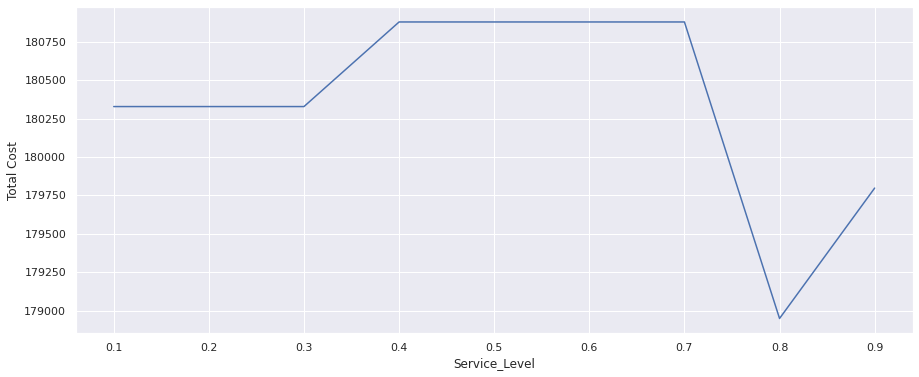

In [148]:
#plotting the risk vs cost 
plt.figure(figsize=(15,6))
sns.lineplot(x="Service_Level", y="Total Cost", data=risk_analysis_2019)
plt.show()

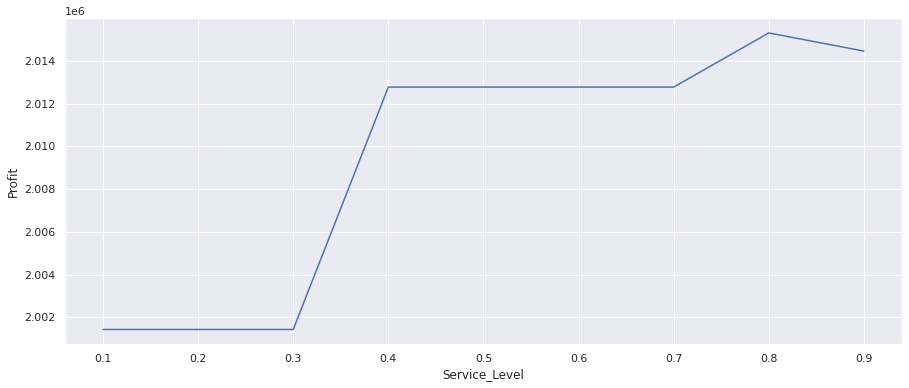

In [149]:
#plotting the risk vs profit 
plt.figure(figsize=(15,6))
sns.lineplot(x="Service_Level", y="Profit", data=risk_analysis_2019)
plt.show()

# 2020 Stockout Risk

In [150]:
#dividing up the deamnd into two instances: prior to the holidays and the holidays (before november and after)
monthlyinv2020=monthlyinv[monthlyinv['Year']==2020]
non_hol_dem_2020=monthlyinv2020[monthlyinv2020['Month'].isin(['January','February','March','April','May','June','July','August','September','October','November'])]
hol_dem_2020=monthlyinv2020[monthlyinv2020['Month'].isin(['November','December'])]

In [151]:
#Total Yearly Demand
total_nonhol_dem_2020=non_hol_dem_2020['Demand'].sum()
total_hol_dem_2020=hol_dem_2020['Demand'].sum()
print('Total Non Holiday Demand:',total_nonhol_dem_2020)
print('Total Holiday Demand:',total_hol_dem_2020)

Total Non Holiday Demand: 87978
Total Holiday Demand: 20187


In [152]:
monthlyinv2020=monthlyinv[monthlyinv['Year']==2020]
non_hol_dem_2020=monthlyinv2020[monthlyinv2020['Month'].isin(['January','February','March','April','May','June','July','August','September','October'])]
hol_dem_2020=monthlyinv2020[monthlyinv2020['Month'].isin(['November','December'])]

In [153]:
#setup cost per order
setupcost=1200
#holding cost per unit inventory
holdingcost=0.25

In [154]:
#number of days in november and december
number_of_hol_days= 61
#number of days during the non holiday period
number_of_non_hol_days=304

In [155]:
NonHolQ2020=math.sqrt(((total_nonhol_dem_2020/number_of_non_hol_days)*2*setupcost)/holdingcost)
HolQ2020=math.sqrt(((total_hol_dem_2020/number_of_hol_days)*2*setupcost)/holdingcost)
print('2020 optimal Q on holidays:',HolQ2020)
print('2020 optimal Q on non holidays:',NonHolQ2020)

2020 optimal Q on holidays: 1782.4058156893673
2020 optimal Q on non holidays: 1666.8091167194123


In [156]:
#number of orders per season
NumOrders2020hol=total_hol_dem_2020/HolQ2020
NumOrders2020nonhol=total_nonhol_dem_2020/NonHolQ2020
print('2020 optimal number of orders during holidays:',NumOrders2020hol)
print('2020 optimal number of orders during non holidays:',NumOrders2020nonhol)

2020 optimal number of orders during holidays: 11.325703620526188
2020 optimal number of orders during non holidays: 52.782288696114726


In [157]:
monthlymean2020=yearmean[yearmean['Year']==2020]
non_hol_mean_2020=monthlymean2020[monthlymean2020['Month'].isin(['January','February','March','April','May','June','July','August','September','October'])]
hol_mean_2020=monthlymean2020[monthlymean2020['Month'].isin(['November','December'])]

In [159]:
#average demand per day
Average_Demand_nonhol_2020=non_hol_mean_2020['Demand'].mean()
Average_Demand_hol_2020=hol_mean_2020['Demand'].mean()

#reorder point calculation
LeadTime=9
ROP2020hol= Average_Demand_hol_2020*LeadTime
ROP2020nonhol= Average_Demand_nonhol_2020*LeadTime
print('ROP 2020 during holidays:',ROP2020hol)
print('ROP 2020 not during holidays:',ROP2020nonhol)

ROP 2020 during holidays: 2976.5370967741937
ROP 2020 not during holidays: 2316.738020022247


In [160]:
risk_analysis_2020=pd.DataFrame()
service_level_list=[]
for i in range(10,100,10):
  service_level_list.append(i/100)
risk_analysis_2020['Service_Level']=pd.DataFrame(service_level_list)
risk_analysis_2020['Profit']=0
risk_analysis_2020['Revenue']=0
risk_analysis_2020['Storage_Costs']=0
risk_analysis_2020['Batch_Costs']=0
risk_analysis_2020['Stock_Out_Lost_Demand']=0
risk_analysis_2020['Lost Revenue']=0
risk_analysis_2020

,Service_Level,Profit,Revenue,Storage_Costs,Batch_Costs,Stock_Out_Lost_Demand,Lost Revenue
0,0.1,0,0,0,0,0,0
1,0.2,0,0,0,0,0,0
2,0.3,0,0,0,0,0,0
3,0.4,0,0,0,0,0,0
4,0.5,0,0,0,0,0,0
5,0.6,0,0,0,0,0,0
6,0.7,0,0,0,0,0,0
7,0.8,0,0,0,0,0,0
8,0.9,0,0,0,0,0,0


In [185]:
EOQ_2020= dfInventory.loc[dfInventory['Year'] == 2020]
EOQ_2020= EOQ_2020.drop(['Inventory','Year','StorageCost','Revenue'],axis=1)
EOQ_2020['Inventory']=5000
EOQ_2020['Batch_Costs']=0
EOQ_2020['Revenue']=0
EOQ_2020['Storage_Costs']=0
EOQ_2020

,Day,Demand,Month,Inventory,Batch_Costs,Revenue,Storage_Costs
365,1/1/2020,185,January,5000,0,0,0
366,1/2/2020,256,January,5000,0,0,0
367,1/3/2020,266,January,5000,0,0,0
368,1/4/2020,177,January,5000,0,0,0
369,1/5/2020,422,January,5000,0,0,0
...,...,...,...,...,...,...,...
726,12/27/2020,459,December,5000,0,0,0
727,12/28/2020,603,December,5000,0,0,0
728,12/29/2020,199,December,5000,0,0,0
729,12/30/2020,422,December,5000,0,0,0


In [187]:
#starting inv was 11058
previousinv=11058
i=80
counter=0
service_level=i/100
for index, row in EOQ_2020.iterrows():
  EOQ_2020.loc[index, 'Served_Demand']=previousinv-row['Inventory']
  row['Inventory']=previousinv-row['Demand']
  previousinv=row['Inventory']
  EOQ_2020.loc[index, 'Inventory']=row['Inventory']
  EOQ_2020.loc[index, 'Lost Sales']=0

  if row['Month']!='November' and row['Month']!='December':
    if row['Inventory']<=(nbinom.ppf(n=45,p=0.02,q=service_level)):
      counter+=1
      if counter>9:
        EOQ_2020.loc[index, 'Inventory']= EOQ_2020.loc[index, 'Inventory']+round(NonHolQ2020)
        EOQ_2020.loc[index, 'Served_Demand']= EOQ_2020.loc[index, 'Served_Demand']+round(NonHolQ2020)
        EOQ_2020.loc[index, 'Batch_Costs']= 1200+(1.50*round(NonHolQ2020))
        previousinv+=round(NonHolQ2020)
        counter=0

  if row['Month']=='November' or row['Month']=='December':
    if row['Inventory']<=(nbinom.ppf(n=45,p=0.02,q=service_level)+70):
      counter+=1
      if counter>9:
        EOQ_2020.loc[index, 'Inventory']= EOQ_2020.loc[index, 'Inventory']+round(HolQ2020)
        EOQ_2020.loc[index, 'Served_Demand']= EOQ_2020.loc[index, 'Served_Demand']+round(HolQ2020)
        EOQ_2020.loc[index, 'Batch_Costs']= 1200+(1.50*round(HolQ2020))
        previousinv+=round(HolQ2020)
        counter=0
    
  if previousinv<0:
    EOQ_2020.loc[index, 'Lost Sales']=row['Inventory']*-1
    EOQ_2020.loc[index, 'Inventory']=0
    previousinv=0
  
EOQ_2020['Revenue']= EOQ_2020['Served_Demand']*35.50
EOQ_2020['Storage_Costs']= EOQ_2020['Inventory']*0.25
EOQ_2020['Profit']=EOQ_2020['Revenue']-EOQ_2020['Storage_Costs']-EOQ_2020['Batch_Costs']
EOQ_2020['Lost Revenue']=EOQ_2020['Lost Sales']*35.5
risk_analysis_2020.loc[risk_analysis_2020['Service_Level'] == service_level,'Revenue']=EOQ_2020['Revenue'].sum()
risk_analysis_2020.loc[risk_analysis_2020['Service_Level'] == service_level,'Batch_Costs']=EOQ_2020['Batch_Costs'].sum()
risk_analysis_2020.loc[risk_analysis_2020['Service_Level'] == service_level,'Storage_Costs']=EOQ_2020['Storage_Costs'].sum()
risk_analysis_2020.loc[risk_analysis_2020['Service_Level'] == service_level,'Profit']=EOQ_2020['Profit'].sum()
risk_analysis_2020.loc[risk_analysis_2020['Service_Level'] == service_level,'Lost Revenue']=EOQ_2020['Lost Revenue'].sum()
risk_analysis_2020.loc[risk_analysis_2020['Service_Level'] == service_level,'Stock_Out_Lost_Demand']=EOQ_2020['Lost Sales'].sum()
risk_analysis_2020

,Service_Level,Profit,Revenue,Storage_Costs,Batch_Costs,Stock_Out_Lost_Demand,Lost Revenue
0,0.1,2103967.25,2325995.5,98704.25,123324.0,33103,1175156.5
1,0.2,2116348.25,2336894.0,97394.25,123151.5,32796,1164258.0
2,0.3,2116348.25,2336894.0,97394.25,123151.5,32796,1164258.0
3,0.4,2116348.25,2336894.0,97394.25,123151.5,32796,1164258.0
4,0.5,2116348.25,2336894.0,97394.25,123151.5,32796,1164258.0
5,0.6,2122934.50,2343958.5,97872.50,123151.5,32597,1157193.5
6,0.7,2122934.50,2343958.5,97872.50,123151.5,32597,1157193.5
7,0.8,2122934.50,2343958.5,97872.50,123151.5,32597,1157193.5
8,0.9,2145006.00,2365365.0,97207.50,123151.5,31994,1135787.0


In [188]:
risk_analysis_2020['Total Cost']=risk_analysis_2020['Storage_Costs']+risk_analysis_2020['Batch_Costs']

In [189]:
risk_analysis_2020

,Service_Level,Profit,Revenue,Storage_Costs,Batch_Costs,Stock_Out_Lost_Demand,Lost Revenue,Total Cost
0,0.1,2103967.25,2325995.5,98704.25,123324.0,33103,1175156.5,222028.25
1,0.2,2116348.25,2336894.0,97394.25,123151.5,32796,1164258.0,220545.75
2,0.3,2116348.25,2336894.0,97394.25,123151.5,32796,1164258.0,220545.75
3,0.4,2116348.25,2336894.0,97394.25,123151.5,32796,1164258.0,220545.75
4,0.5,2116348.25,2336894.0,97394.25,123151.5,32796,1164258.0,220545.75
5,0.6,2122934.50,2343958.5,97872.50,123151.5,32597,1157193.5,221024.00
6,0.7,2122934.50,2343958.5,97872.50,123151.5,32597,1157193.5,221024.00
7,0.8,2122934.50,2343958.5,97872.50,123151.5,32597,1157193.5,221024.00
8,0.9,2145006.00,2365365.0,97207.50,123151.5,31994,1135787.0,220359.00


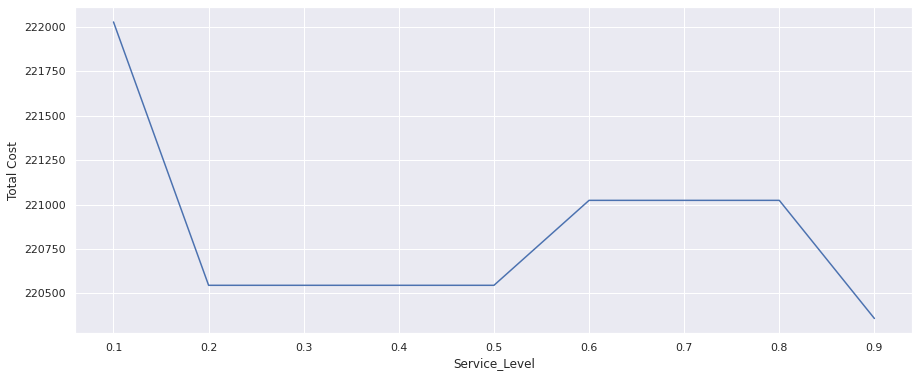

In [190]:
#plotting the risk vs cost 
plt.figure(figsize=(15,6))
sns.lineplot(x="Service_Level", y="Total Cost", data=risk_analysis_2020)
plt.show()

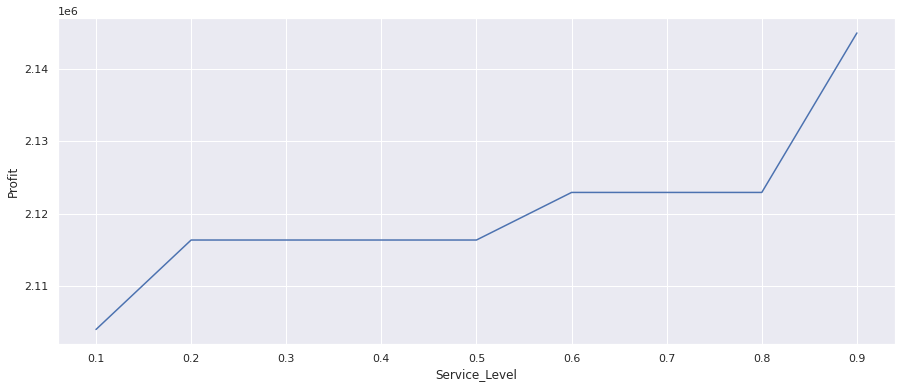

In [191]:
#plotting the risk vs profit 
plt.figure(figsize=(15,6))
sns.lineplot(x="Service_Level", y="Profit", data=risk_analysis_2020)
plt.show()

#2021 Stockout Risk

In [204]:
#dividing up the deamnd into two instances: prior to the holidays and the holidays (before november and after)
monthlyinv2021=monthlyinv[monthlyinv['Year']==2021]
non_hol_dem_2021=monthlyinv2021[monthlyinv2021['Month'].isin(['January','February','March','April','May','June','July','August','September','October','November'])]
hol_dem_2021=monthlyinv2021[monthlyinv2021['Month'].isin(['November','December'])]

In [205]:
#Total Yearly Demand
total_nonhol_dem_2021=non_hol_dem_2021['Demand'].sum()
total_hol_dem_2021=hol_dem_2021['Demand'].sum()
print('Total Non Holiday Demand:',total_nonhol_dem_2021)
print('Total Holiday Demand:',total_hol_dem_2021)

Total Non Holiday Demand: 95646
Total Holiday Demand: 21949


In [206]:
monthlyinv2021=monthlyinv[monthlyinv['Year']==2021]
non_hol_dem_2021=monthlyinv2021[monthlyinv2021['Month'].isin(['January','February','March','April','May','June','July','August','September','October'])]
hol_dem_2021=monthlyinv2020[monthlyinv2020['Month'].isin(['November','December'])]

In [207]:
#setup cost per order
setupcost=1200
#holding cost per unit inventory
holdingcost=0.25

In [208]:
#number of days in november and december
number_of_hol_days= 61
#number of days during the non holiday period
number_of_non_hol_days=304

In [209]:
NonHolQ2021=math.sqrt(((total_nonhol_dem_2021/number_of_non_hol_days)*2*setupcost)/holdingcost)
HolQ2021=math.sqrt(((total_hol_dem_2021/number_of_hol_days)*2*setupcost)/holdingcost)
print('2021 optimal Q on holidays:',HolQ2021)
print('2021 optimal Q on non holidays:',NonHolQ2021)

2021 optimal Q on holidays: 1858.566343303089
2021 optimal Q on non holidays: 1737.9298029552288


In [210]:
#number of orders per season
NumOrders2021hol=total_hol_dem_2021/HolQ2021
NumOrders2021nonhol=total_nonhol_dem_2021/NonHolQ2021
print('2021 optimal number of orders during holidays:',NumOrders2021hol)
print('2021 optimal number of orders during non holidays:',NumOrders2021nonhol)

2021 optimal number of orders during holidays: 11.809640306405047
2021 optimal number of orders during non holidays: 55.034443760248905


In [211]:
monthlymean2021=yearmean[yearmean['Year']==2021]
non_hol_mean_2021=monthlymean2021[monthlymean2021['Month'].isin(['January','February','March','April','May','June','July','August','September','October'])]
hol_mean_2021=monthlymean2021[monthlymean2021['Month'].isin(['November','December'])]

In [212]:
non_hol_mean_2021

,Year,Month,Inventory,Demand,StorageCost,Revenue
24,2021,April,9838.333333,284.633333,2459.583333,10104.483333
25,2021,August,8991.612903,300.322581,2247.903226,10661.451613
27,2021,February,10618.892857,283.892857,2654.723214,10078.196429
28,2021,January,11083.161290,304.677419,2770.790323,10816.048387
29,2021,July,9760.129032,272.193548,2440.032258,9662.870968
30,2021,June,9880.100000,258.933333,2470.025000,9192.133333
31,2021,March,10814.483871,279.419355,2703.620968,9919.387097
32,2021,May,9575.193548,269.000000,2393.798387,9549.500000
34,2021,October,8770.806452,280.870968,2192.701613,9970.919355
35,2021,September,8743.933333,258.333333,2185.983333,9170.833333


In [213]:
#average demand per day


Average_Demand_nonhol_2021=non_hol_mean_2021['Demand'].mean()
Average_Demand_hol_2021=hol_mean_2021['Demand'].mean()

#reorder point calculation
LeadTime=9
ROP2021hol= Average_Demand_hol_2021*LeadTime
ROP2021nonhol= Average_Demand_nonhol_2021*LeadTime
print('ROP 2021 during holidays:',ROP2021hol)
print('ROP 2021 not during holidays:',ROP2021nonhol)

ROP 2021 during holidays: 3238.1080645161287
ROP 2021 not during holidays: 2513.0490552995398


In [214]:
risk_analysis_2021=pd.DataFrame()
service_level_list=[]
for i in range(10,100,10):
  service_level_list.append(i/100)
risk_analysis_2021['Service_Level']=pd.DataFrame(service_level_list)
risk_analysis_2021['Profit']=0
risk_analysis_2021['Revenue']=0
risk_analysis_2021['Storage_Costs']=0
risk_analysis_2021['Batch_Costs']=0
risk_analysis_2021['Stock_Out_Lost_Demand']=0
risk_analysis_2021['Lost Revenue']=0
risk_analysis_2021

,Service_Level,Profit,Revenue,Storage_Costs,Batch_Costs,Stock_Out_Lost_Demand,Lost Revenue
0,0.1,0,0,0,0,0,0
1,0.2,0,0,0,0,0,0
2,0.3,0,0,0,0,0,0
3,0.4,0,0,0,0,0,0
4,0.5,0,0,0,0,0,0
5,0.6,0,0,0,0,0,0
6,0.7,0,0,0,0,0,0
7,0.8,0,0,0,0,0,0
8,0.9,0,0,0,0,0,0


In [239]:
EOQ_2021= dfInventory.loc[dfInventory['Year'] == 2021]
EOQ_2021= EOQ_2021.drop(['Inventory','Year','StorageCost','Revenue'],axis=1)
EOQ_2021['Inventory']=5000
EOQ_2021['Batch_Costs']=0
EOQ_2021['Revenue']=0
EOQ_2021['Storage_Costs']=0
EOQ_2021

,Day,Demand,Month,Inventory,Batch_Costs,Revenue,Storage_Costs
731,1/1/2021,349,January,5000,0,0,0
732,1/2/2021,382,January,5000,0,0,0
733,1/3/2021,204,January,5000,0,0,0
734,1/4/2021,390,January,5000,0,0,0
735,1/5/2021,340,January,5000,0,0,0
...,...,...,...,...,...,...,...
1091,12/27/2021,255,December,5000,0,0,0
1092,12/28/2021,308,December,5000,0,0,0
1093,12/29/2021,407,December,5000,0,0,0
1094,12/30/2021,329,December,5000,0,0,0


In [241]:
#starting inv was 10234
previousinv=10234
i=90
counter=0
service_level=i/100
for index, row in EOQ_2021.iterrows():
  EOQ_2021.loc[index, 'Served_Demand']=previousinv-row['Inventory']
  row['Inventory']=previousinv-row['Demand']
  previousinv=row['Inventory']
  EOQ_2021.loc[index, 'Inventory']=row['Inventory']
  EOQ_2021.loc[index, 'Lost Sales']=0

  if row['Month']!='November' and row['Month']!='December':
    if row['Inventory']<=(nbinom.ppf(n=45,p=0.02,q=service_level)):
      counter+=1
      if counter>9:
        EOQ_2021.loc[index, 'Inventory']= EOQ_2021.loc[index, 'Inventory']+round(NonHolQ2021)
        EOQ_2021.loc[index, 'Served_Demand']= EOQ_2021.loc[index, 'Served_Demand']+round(NonHolQ2021)
        EOQ_2021.loc[index, 'Batch_Costs']= 1200+(1.50*round(NonHolQ2021))
        previousinv+=round(NonHolQ2021)
        counter=0

  if row['Month']=='November' or row['Month']=='December':
    if row['Inventory']<=(nbinom.ppf(n=45,p=0.02,q=service_level)+70):
      counter+=1
      if counter>9:
        EOQ_2021.loc[index, 'Inventory']= EOQ_2021.loc[index, 'Inventory']+round(HolQ2021)
        EOQ_2021.loc[index, 'Served_Demand']= EOQ_2021.loc[index, 'Served_Demand']+round(HolQ2021)
        EOQ_2021.loc[index, 'Batch_Costs']= 1200+(1.50*round(HolQ2021))
        previousinv+=round(HolQ2021)
        counter=0
    
  if previousinv<0:
    EOQ_2021.loc[index, 'Lost Sales']=row['Inventory']*-1
    EOQ_2021.loc[index, 'Inventory']=0
    previousinv=0
  
EOQ_2021['Revenue']= EOQ_2021['Served_Demand']*35.50
EOQ_2021['Storage_Costs']= EOQ_2021['Inventory']*0.25
EOQ_2021['Profit']=EOQ_2021['Revenue']-EOQ_2021['Storage_Costs']-EOQ_2021['Batch_Costs']
EOQ_2021['Lost Revenue']=EOQ_2021['Lost Sales']*35.5
risk_analysis_2021.loc[risk_analysis_2021['Service_Level'] == service_level,'Revenue']=EOQ_2021['Revenue'].sum()
risk_analysis_2021.loc[risk_analysis_2021['Service_Level'] == service_level,'Batch_Costs']=EOQ_2021['Batch_Costs'].sum()
risk_analysis_2021.loc[risk_analysis_2021['Service_Level'] == service_level,'Storage_Costs']=EOQ_2021['Storage_Costs'].sum()
risk_analysis_2021.loc[risk_analysis_2021['Service_Level'] == service_level,'Profit']=EOQ_2021['Profit'].sum()
risk_analysis_2021.loc[risk_analysis_2021['Service_Level'] == service_level,'Lost Revenue']=EOQ_2021['Lost Revenue'].sum()
risk_analysis_2021.loc[risk_analysis_2021['Service_Level'] == service_level,'Stock_Out_Lost_Demand']=EOQ_2021['Lost Sales'].sum()
risk_analysis_2021

,Service_Level,Profit,Revenue,Storage_Costs,Batch_Costs,Stock_Out_Lost_Demand,Lost Revenue
0,0.1,2220628.5,2425147,77798.5,126720.0,38542,1368241
1,0.2,2220628.5,2425147,77798.5,126720.0,38542,1368241
2,0.3,2220628.5,2425147,77798.5,126720.0,38542,1368241
3,0.4,2230475.5,2439844,78660.0,130708.5,38128,1353544
4,0.5,2230475.5,2439844,78660.0,130708.5,38128,1353544
5,0.6,2230475.5,2439844,78660.0,130708.5,38128,1353544
6,0.7,2237734.5,2447228,78966.5,130527.0,37920,1346160
7,0.8,2237734.5,2447228,78966.5,130527.0,37920,1346160
8,0.9,2237734.5,2447228,78966.5,130527.0,37920,1346160


In [242]:
risk_analysis_2021['Total Cost']=risk_analysis_2021['Storage_Costs']+risk_analysis_2021['Batch_Costs']

In [ ]:
risk_analysis_2021

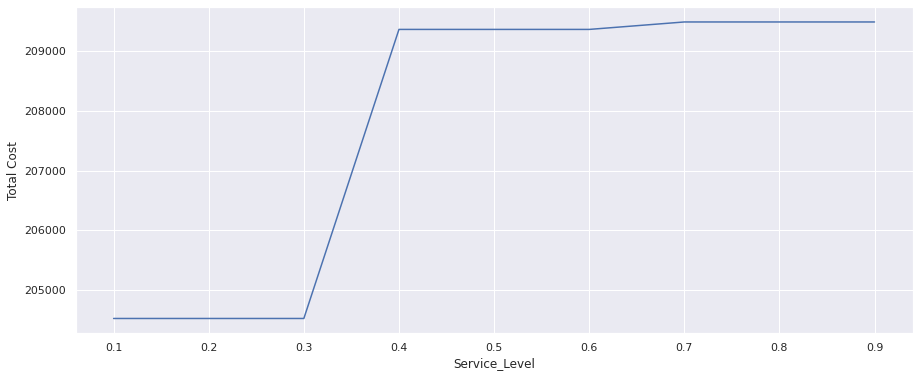

In [243]:
#plotting the risk vs cost 
plt.figure(figsize=(15,6))
sns.lineplot(x="Service_Level", y="Total Cost", data=risk_analysis_2021)
plt.show()

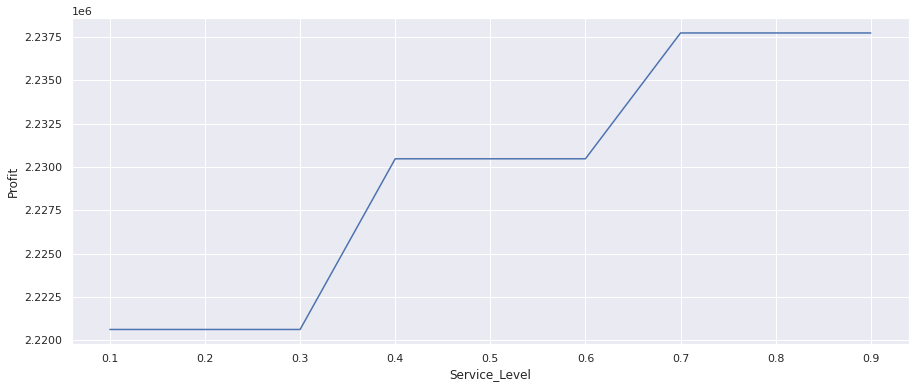

In [244]:
#plotting the risk vs profit 
plt.figure(figsize=(15,6))
sns.lineplot(x="Service_Level", y="Profit", data=risk_analysis_2021)
plt.show()

# 2022 Stockout Risk

In [245]:
EOQ_2022=forecast.copy()
EOQ_2022=EOQ_2022.drop(['DayofMonth','Served_Demand','Lost Sales','Revenue','StorageCost'],axis=1)
EOQ_2022

,Demand,Day,Inventory,Month
0,414,2022-01-01,764,January
1,237,2022-01-02,527,January
2,243,2022-01-03,284,January
3,232,2022-01-04,52,January
4,125,2022-01-05,0,January
...,...,...,...,...
360,437,2022-12-27,1116,December
361,416,2022-12-28,700,December
362,400,2022-12-29,300,December
363,234,2022-12-30,66,December


In [246]:
#dividing up the demand into two instances: prior to the holidays and the holidays (before november and after)
non_hol_dem_2022=EOQ_2022[EOQ_2022['Month'].isin(['January','February','March','April','May','June','July','August','September','October','November'])]
hol_dem_2022=EOQ_2022[EOQ_2022['Month'].isin(['November','December'])]

In [247]:
#Total Yearly Demand
total_nonhol_dem_2022=non_hol_dem_2022['Demand'].sum()
total_hol_dem_2022=hol_dem_2022['Demand'].sum()
print('Total Non Holiday Demand:',total_nonhol_dem_2022)
print('Total Holiday Demand:',total_hol_dem_2022)

Total Non Holiday Demand: 91227
Total Holiday Demand: 21185


In [248]:
#setup cost per order
setupcost=1200
#holding cost per unit inventory
holdingcost=0.25

In [249]:
#number of days in november and december
number_of_hol_days= 61
#number of days during the non holiday period
number_of_non_hol_days=304

In [250]:
NonHolQ2022=math.sqrt(((total_nonhol_dem_2022/number_of_non_hol_days)*2*setupcost)/holdingcost)
HolQ2022=math.sqrt(((total_hol_dem_2022/number_of_hol_days)*2*setupcost)/holdingcost)
print('2022 optimal Q on holidays:',HolQ2022)
print('2022 optimal Q on non holidays:',NonHolQ2022)

2022 optimal Q on holidays: 1825.933401547068
2022 optimal Q on non holidays: 1697.3074652457483


In [251]:
#number of orders per season
NumOrders2022hol=total_hol_dem_2022/HolQ2022
NumOrders2022nonhol=total_nonhol_dem_2022/NonHolQ2022
print('2022 optimal number of orders during holidays:',NumOrders2022hol)
print('2022 optimal number of orders during non holidays:',NumOrders2022nonhol)

2022 optimal number of orders during holidays: 11.60228515566366
2022 optimal number of orders during non holidays: 53.748069732782035


In [252]:
mean_2022=EOQ_2022.groupby(['Month']).agg('mean').reset_index()
mean_2022

,Month,Demand,Inventory
0,April,232.566667,4066.700000
1,August,242.935484,4619.806452
2,December,371.419355,2761.290323
3,February,277.321429,4142.928571
4,January,257.903226,3716.774194
5,July,287.032258,4679.806452
6,June,271.466667,4716.533333
7,March,295.096774,4383.935484
8,May,255.129032,4903.516129
9,November,322.366667,3534.100000


In [253]:
non_hol_mean_2022=mean_2022[mean_2022['Month'].isin(['January','February','March','April','May','June','July','August','September','October'])]
hol_mean_2022=mean_2022[mean_2022['Month'].isin(['November','December'])]

In [254]:
non_hol_mean_2022

,Month,Demand,Inventory
0,April,232.566667,4066.700000
1,August,242.935484,4619.806452
3,February,277.321429,4142.928571
4,January,257.903226,3716.774194
5,July,287.032258,4679.806452
6,June,271.466667,4716.533333
7,March,295.096774,4383.935484
8,May,255.129032,4903.516129
10,October,278.032258,4171.000000
11,September,285.666667,4551.833333


In [255]:
#average demand per day
Average_Demand_nonhol_2022=non_hol_mean_2022['Demand'].mean()
Average_Demand_hol_2022=hol_mean_2022['Demand'].mean()

#reorder point calculation
LeadTime=9
ROP2022hol= Average_Demand_hol_2022*LeadTime
ROP2022nonhol= Average_Demand_nonhol_2022*LeadTime
print('ROP 2022 during holidays:',ROP2022hol)
print('ROP 2022 not during holidays:',ROP2022nonhol)

ROP 2022 during holidays: 3122.0370967741933
ROP 2022 not during holidays: 2414.8354147465434


In [256]:
risk_analysis_2022=pd.DataFrame()
service_level_list=[]
for i in range(10,100,10):
  service_level_list.append(i/100)
risk_analysis_2022['Service_Level']=pd.DataFrame(service_level_list)
risk_analysis_2022['Profit']=0
risk_analysis_2022['Revenue']=0
risk_analysis_2022['Storage_Costs']=0
risk_analysis_2022['Batch_Costs']=0
risk_analysis_2022['Stock_Out_Lost_Demand']=0
risk_analysis_2022['Lost Revenue']=0
risk_analysis_2022

,Service_Level,Profit,Revenue,Storage_Costs,Batch_Costs,Stock_Out_Lost_Demand,Lost Revenue
0,0.1,0,0,0,0,0,0
1,0.2,0,0,0,0,0,0
2,0.3,0,0,0,0,0,0
3,0.4,0,0,0,0,0,0
4,0.5,0,0,0,0,0,0
5,0.6,0,0,0,0,0,0
6,0.7,0,0,0,0,0,0
7,0.8,0,0,0,0,0,0
8,0.9,0,0,0,0,0,0


In [299]:
EOQ_2022['Inventory']=5000
EOQ_2022['Batch_Costs']=0
EOQ_2022['Revenue']=0
EOQ_2022['Storage_Costs']=0
EOQ_2022

,Demand,Day,Inventory,Month,Batch_Costs,Revenue,Storage_Costs,Served_Demand,Lost Sales,Profit,Lost Revenue
0,414,2022-01-01,5000,January,0,0,0,414.0,0.0,14506.00,0.0
1,237,2022-01-02,5000,January,0,0,0,237.0,0.0,8281.75,0.0
2,243,2022-01-03,5000,January,0,0,0,243.0,0.0,8555.50,0.0
3,232,2022-01-04,5000,January,0,0,0,232.0,0.0,8223.00,0.0
4,125,2022-01-05,5000,January,0,0,0,52.0,73.0,1846.00,2591.5
...,...,...,...,...,...,...,...,...,...,...,...
360,437,2022-12-27,5000,December,0,0,0,437.0,0.0,15288.50,0.0
361,416,2022-12-28,5000,December,0,0,0,416.0,0.0,14647.00,0.0
362,400,2022-12-29,5000,December,0,0,0,400.0,0.0,14179.00,0.0
363,234,2022-12-30,5000,December,0,0,0,84.0,150.0,2982.00,5325.0


In [301]:
#starting inv was 1178
previousinv=1178
i=90
counter=0
service_level=i/100
for index, row in EOQ_2022.iterrows():
  EOQ_2022.loc[index, 'Served_Demand']=previousinv-row['Inventory']
  row['Inventory']=previousinv-row['Demand']
  previousinv=row['Inventory']
  EOQ_2022.loc[index, 'Inventory']=row['Inventory']
  EOQ_2022.loc[index, 'Lost Sales']=0

  if row['Month']!='November' and row['Month']!='December':
    if row['Inventory']<=(nbinom.ppf(n=45,p=0.02,q=service_level)):
      counter+=1
      if counter>9:
        EOQ_2022.loc[index, 'Inventory']= EOQ_2022.loc[index, 'Inventory']+round(NonHolQ2022)
        EOQ_2022.loc[index, 'Served_Demand']= EOQ_2022.loc[index, 'Served_Demand']+round(NonHolQ2022)
        EOQ_2022.loc[index, 'Batch_Costs']= 1200+(1.50*round(NonHolQ2022))
        previousinv+=round(NonHolQ2022)
        counter=0

  if row['Month']=='November' or row['Month']=='December':
    if row['Inventory']<=(nbinom.ppf(n=45,p=0.02,q=service_level)+708):
      counter+=1
      if counter>9:
        EOQ_2022.loc[index, 'Inventory']= EOQ_2022.loc[index, 'Inventory']+round(HolQ2022)
        EOQ_2022.loc[index, 'Served_Demand']= EOQ_2022.loc[index, 'Served_Demand']+round(HolQ2022)
        EOQ_2022.loc[index, 'Batch_Costs']= 1200+(1.50*round(HolQ2022))
        previousinv+=round(HolQ2022)
        counter=0
    
  if previousinv<0:
    EOQ_2022.loc[index, 'Lost Sales']=row['Inventory']*-1
    EOQ_2022.loc[index, 'Inventory']=0
    previousinv=0
  
EOQ_2022['Revenue']= EOQ_2022['Served_Demand']*35.50
EOQ_2022['Storage_Costs']= EOQ_2022['Inventory']*0.25
EOQ_2022['Profit']=EOQ_2022['Revenue']-EOQ_2022['Storage_Costs']-EOQ_2022['Batch_Costs']
EOQ_2022['Lost Revenue']=EOQ_2022['Lost Sales']*35.5
risk_analysis_2022.loc[risk_analysis_2022['Service_Level'] == service_level,'Revenue']=EOQ_2022['Revenue'].sum()
risk_analysis_2022.loc[risk_analysis_2022['Service_Level'] == service_level,'Batch_Costs']=EOQ_2022['Batch_Costs'].sum()
risk_analysis_2022.loc[risk_analysis_2022['Service_Level'] == service_level,'Storage_Costs']=EOQ_2022['Storage_Costs'].sum()
risk_analysis_2022.loc[risk_analysis_2022['Service_Level'] == service_level,'Profit']=EOQ_2022['Profit'].sum()
risk_analysis_2022.loc[risk_analysis_2022['Service_Level'] == service_level,'Lost Revenue']=EOQ_2022['Lost Revenue'].sum()
risk_analysis_2022.loc[risk_analysis_2022['Service_Level'] == service_level,'Stock_Out_Lost_Demand']=EOQ_2022['Lost Sales'].sum()
risk_analysis_2022

,Service_Level,Profit,Revenue,Storage_Costs,Batch_Costs,Stock_Out_Lost_Demand,Lost Revenue
0,0.1,2061473,2238062,40590,135999,39697,1409243.5
1,0.2,2061473,2238062,40590,135999,39697,1409243.5
2,0.3,2061473,2238062,40590,135999,39697,1409243.5
3,0.4,2061473,2238062,40590,135999,39697,1409243.5
4,0.5,2061473,2238062,40590,135999,39697,1409243.5
5,0.6,2061473,2238062,40590,135999,39697,1409243.5
6,0.7,2061473,2238062,40590,135999,39697,1409243.5
7,0.8,2061473,2238062,40590,135999,39697,1409243.5
8,0.9,2061473,2238062,40590,135999,39697,1409243.5


In [310]:
service_level=0.1
nbinom.ppf(n=45,p=0.02,q=service_level)

1791.0

In [302]:
risk_analysis_2022['Total Cost']=risk_analysis_2022['Storage_Costs']+risk_analysis_2022['Batch_Costs']

In [303]:
risk_analysis_2022

,Service_Level,Profit,Revenue,Storage_Costs,Batch_Costs,Stock_Out_Lost_Demand,Lost Revenue,Total Cost
0,0.1,2061473,2238062,40590,135999,39697,1409243.5,176589
1,0.2,2061473,2238062,40590,135999,39697,1409243.5,176589
2,0.3,2061473,2238062,40590,135999,39697,1409243.5,176589
3,0.4,2061473,2238062,40590,135999,39697,1409243.5,176589
4,0.5,2061473,2238062,40590,135999,39697,1409243.5,176589
5,0.6,2061473,2238062,40590,135999,39697,1409243.5,176589
6,0.7,2061473,2238062,40590,135999,39697,1409243.5,176589
7,0.8,2061473,2238062,40590,135999,39697,1409243.5,176589
8,0.9,2061473,2238062,40590,135999,39697,1409243.5,176589


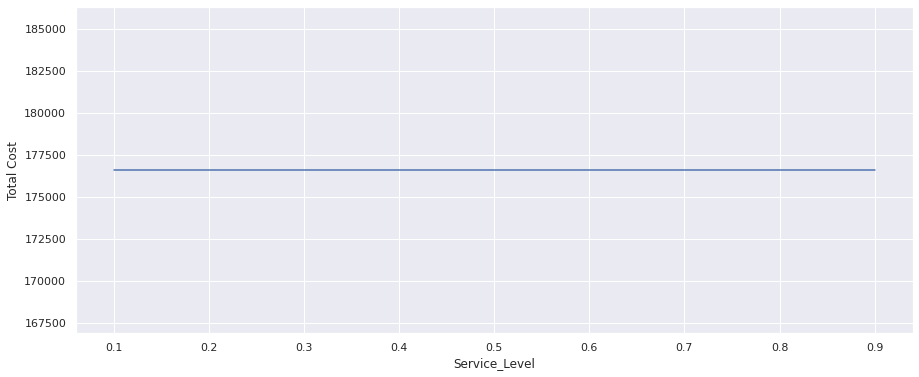

In [304]:
#plotting the risk vs cost 
plt.figure(figsize=(15,6))
sns.lineplot(x="Service_Level", y="Total Cost", data=risk_analysis_2022)
plt.show()

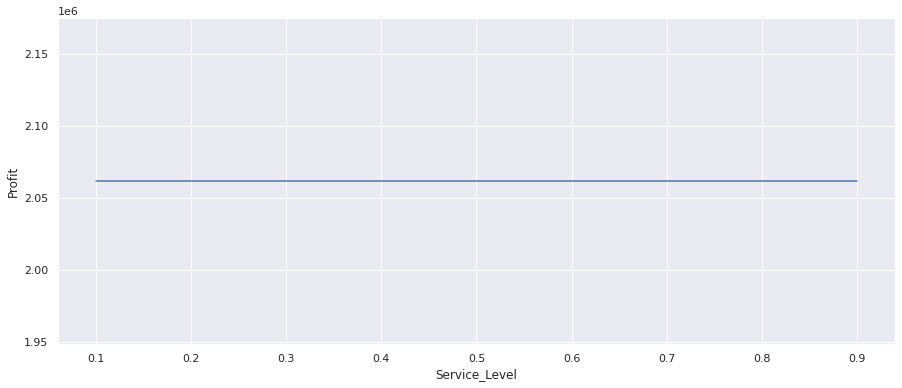

In [305]:
#plotting the risk vs profit 
plt.figure(figsize=(15,6))
sns.lineplot(x="Service_Level", y="Profit", data=risk_analysis_2022)
plt.show()

# Flexible Model Implementation

#2019 Flexible

In [311]:
#dividing up the deamnd into two instances: prior to the holidays and the holidays (before november and after)
monthlyinv2019=monthlyinv[monthlyinv['Year']==2019]
non_hol_dem_2019=monthlyinv2019[monthlyinv2019['Month'].isin(['January','February','March','April','May','June','July','August','September','October','November'])]
hol_dem_2019=monthlyinv2019[monthlyinv2019['Month'].isin(['November','December'])]

In [312]:
#Total Yearly Demand
total_nonhol_dem_2019=non_hol_dem_2019['Demand'].sum()
total_hol_dem_2019=hol_dem_2019['Demand'].sum()
print('Total Non Holiday Demand:',total_nonhol_dem_2019)
print('Total Holiday Demand:',total_hol_dem_2019)

Total Non Holiday Demand: 82907
Total Holiday Demand: 17250


In [313]:
monthlyinv2019=monthlyinv[monthlyinv['Year']==2019]
non_hol_dem_2019=monthlyinv2019[monthlyinv2019['Month'].isin(['January','February','March','April','May','June','July','August','September','October'])]
hol_dem_2019=monthlyinv2019[monthlyinv2019['Month'].isin(['November','December'])]

In [314]:
#setup cost per order
setupcost=1200
#holding cost per unit inventory
holdingcost=0.25

In [315]:
#number of days in november and december
number_of_hol_days= 61
#number of days during the non holiday period
number_of_non_hol_days=304

In [316]:
NonHolQ2019=math.sqrt(((total_nonhol_dem_2019/number_of_non_hol_days)*2*setupcost)/holdingcost)
HolQ2019=math.sqrt(((total_hol_dem_2019/number_of_hol_days)*2*setupcost)/holdingcost)
print('2019 optimal Q on holidays:',round(HolQ2019))
print('2019 optimal Q on non holidays:',round(NonHolQ2019))

2019 optimal Q on holidays: 1648
2019 optimal Q on non holidays: 1618


In [317]:
#number of orders per season
NumOrders2019hol=total_hol_dem_2019/HolQ2019
NumOrders2019nonhol=total_nonhol_dem_2019/NonHolQ2019
print('2019 optimal number of orders during holidays:',NumOrders2019hol)
print('2019 optimal number of orders during non holidays:',NumOrders2019nonhol)

2019 optimal number of orders during holidays: 10.469449603489192
2019 optimal number of orders during non holidays: 51.23854343493122


In [318]:
monthlymean2019=yearmean[yearmean['Year']==2019]
non_hol_mean_2019=monthlymean2019[monthlymean2019['Month'].isin(['January','February','March','April','May','June','July','August','September','October'])]
hol_mean_2019=monthlymean2019[monthlymean2019['Month'].isin(['November','December'])]

In [319]:
#average demand per day
Average_Demand_nonhol_2019=non_hol_mean_2019['Demand'].mean()
Average_Demand_hol_2019=hol_mean_2019['Demand'].mean()

#reorder point calculation
LeadTime=9
ROP2019hol= Average_Demand_hol_2019*LeadTime
ROP2019nonhol= Average_Demand_nonhol_2019*LeadTime
print('ROP 2019 during holidays:',ROP2019hol)
print('ROP 2019 not during holidays:',ROP2019nonhol)

ROP 2019 during holidays: 2544.75
ROP 2019 not during holidays: 2207.3181566820276


In [320]:
EOQ_2019= dfInventory.loc[dfInventory['Year'] == 2019]
EOQ_2019= EOQ_2019.drop(['Inventory','Year','StorageCost','Revenue'],axis=1)
EOQ_2019['Inventory']=5000
EOQ_2019['Batch_Costs']=0
EOQ_2019['Revenue']=0
EOQ_2019['Storage_Costs']=0
EOQ_2019

,Day,Demand,Month,Inventory,Batch_Costs,Revenue,Storage_Costs
0,1/1/2019,340,January,5000,0,0,0
1,1/2/2019,336,January,5000,0,0,0
2,1/3/2019,177,January,5000,0,0,0
3,1/4/2019,172,January,5000,0,0,0
4,1/5/2019,513,January,5000,0,0,0
...,...,...,...,...,...,...,...
360,12/27/2019,232,December,5000,0,0,0
361,12/28/2019,227,December,5000,0,0,0
362,12/29/2019,196,December,5000,0,0,0
363,12/30/2019,409,December,5000,0,0,0


In [321]:
#starting inv was 5000
previousinv=5000
counter=0
NonHolQ2019=NonHolQ2019*2
HolQ2019=HolQ2019*2
for index, row in EOQ_2019.iterrows():
  EOQ_2019.loc[index, 'Served_Demand']=previousinv-row['Inventory']
  row['Inventory']=previousinv-row['Demand']
  previousinv=row['Inventory']
  EOQ_2019.loc[index, 'Inventory']=row['Inventory']
  EOQ_2019.loc[index, 'Lost Sales']=0


  if row['Month']!='November' and row['Month']!='December':
    if row['Inventory']<=ROP2019nonhol:
      counter+=1
      if counter>9:
        EOQ_2019.loc[index, 'Inventory']=  EOQ_2019.loc[index, 'Inventory']+round(NonHolQ2019)
        EOQ_2019.loc[index, 'Served_Demand']= EOQ_2019.loc[index, 'Served_Demand']+round(NonHolQ2019)
        EOQ_2019.loc[index, 'Batch_Costs']= 1200+(1.50*round(NonHolQ2019))

        previousinv+=round(NonHolQ2019)
        counter=0

  if row['Month']=='November' or row['Month']=='December':
    if row['Inventory']<=ROP2019hol:
      counter+=1
      if counter>9:
        EOQ_2019.loc[index, 'Inventory']= EOQ_2019.loc[index, 'Inventory']+ round(HolQ2019)
        EOQ_2019.loc[index, 'Served_Demand']= EOQ_2019.loc[index, 'Served_Demand']+round(NonHolQ2019)
        EOQ_2019.loc[index, 'Batch_Costs']= 1200+(1.50*round(HolQ2019))

        previousinv+=round(HolQ2019)
        counter=0

  if previousinv<0:
    EOQ_2019.loc[index, 'Lost Sales']=row['Inventory']*-1
    EOQ_2019.loc[index, 'Inventory']=0
    previousinv=0
  
EOQ_2019['Revenue']=EOQ_2019['Served_Demand']*35.50
EOQ_2019['Storage_Costs']=EOQ_2019['Inventory']*0.25

In [322]:
#starting inv was 5000
previousinv=5000
counter=0
for index, row in EOQ_2019.iterrows():
  EOQ_2019.loc[index, 'Served_Demand']=previousinv-row['Inventory']
  row['Inventory']=previousinv-row['Demand']
  previousinv=row['Inventory']
  EOQ_2019.loc[index, 'Inventory']=row['Inventory']
  EOQ_2019.loc[index, 'Lost Sales']=0


  if row['Month']!='November' and row['Month']!='December':
    if row['Inventory']<=ROP2019nonhol:
      counter+=1
      if counter>9:
        EOQ_2019.loc[index, 'Inventory']=  EOQ_2019.loc[index, 'Inventory']+round(NonHolQ2019)
        EOQ_2019.loc[index, 'Served_Demand']= EOQ_2019.loc[index, 'Served_Demand']+round(NonHolQ2019)
        EOQ_2019.loc[index, 'Batch_Costs']= 1200+(1.50*round(NonHolQ2019))

        previousinv+=round(NonHolQ2019)
        counter=0

  if row['Month']=='November' or row['Month']=='December':
    if row['Inventory']<=ROP2019hol:
      counter+=1
      if counter>9:
        EOQ_2019.loc[index, 'Inventory']= EOQ_2019.loc[index, 'Inventory']+ round(HolQ2019)
        EOQ_2019.loc[index, 'Served_Demand']= EOQ_2019.loc[index, 'Served_Demand']+round(NonHolQ2019)
        EOQ_2019.loc[index, 'Batch_Costs']= 1200+(1.50*round(HolQ2019))

        previousinv+=round(HolQ2019)
        counter=0

  if previousinv<0:
    EOQ_2019.loc[index, 'Lost Sales']=row['Inventory']*-1
    EOQ_2019.loc[index, 'Inventory']=0
    previousinv=0
  
EOQ_2019['Revenue']=EOQ_2019['Served_Demand']*35.50
EOQ_2019['Storage_Costs']=EOQ_2019['Inventory']*0.25

In [323]:
EOQ_2019.to_csv('EOQ_2019.csv',index=False)

In [324]:
EOQ_2019['Profit']=EOQ_2019['Revenue']-EOQ_2019['Storage_Costs']-EOQ_2019['Batch_Costs']
EOQ_2019['Lost Revenue']=EOQ_2019['Lost Sales']*35.5
print('2019 Total Revenue',EOQ_2019['Revenue'].sum())
print('2019 Total Batch Costs',EOQ_2019['Batch_Costs'].sum())
print('2019 Total Storage Costs',EOQ_2019['Storage_Costs'].sum())
print('2019 Total Profit',EOQ_2019['Profit'].sum())
print('2019 Total Lost Revenue',EOQ_2019['Lost Revenue'].sum())

2019 Total Revenue 3186196.0
2019 Total Batch Costs 163900.5
2019 Total Storage Costs 154831.0
2019 Total Profit 2867464.5
2019 Total Lost Revenue 60172.5


In [328]:
print ("Number of Stockout's:",len(EOQ_2019[EOQ_2019['Served_Demand'] == 0.0]))

Number of Stockout's: 2


#2020 Flexible Model

In [329]:
#dividing up the deamnd into two instances: prior to the holidays and the holidays (before november and after)
monthlyinv2020=monthlyinv[monthlyinv['Year']==2020]
non_hol_dem_2020=monthlyinv2020[monthlyinv2020['Month'].isin(['January','February','March','April','May','June','July','August','September','October','November'])]
hol_dem_2020=monthlyinv2020[monthlyinv2020['Month'].isin(['November','December'])]

In [330]:
#Total Yearly Demand
total_nonhol_dem_2020=non_hol_dem_2020['Demand'].sum()
total_hol_dem_2020=hol_dem_2020['Demand'].sum()
print('Total Non Holiday Demand:',total_nonhol_dem_2020)
print('Total Holiday Demand:',total_hol_dem_2020)

Total Non Holiday Demand: 87978
Total Holiday Demand: 20187


In [331]:
monthlyinv2020=monthlyinv[monthlyinv['Year']==2020]
non_hol_dem_2020=monthlyinv2020[monthlyinv2020['Month'].isin(['January','February','March','April','May','June','July','August','September','October'])]
hol_dem_2020=monthlyinv2020[monthlyinv2020['Month'].isin(['November','December'])]

In [332]:
#setup cost per order
setupcost=1200
#holding cost per unit inventory
holdingcost=0.25

In [333]:
#number of days in november and december
number_of_hol_days= 61
#number of days during the non holiday period
number_of_non_hol_days=304

In [334]:
NonHolQ2020=math.sqrt(((total_nonhol_dem_2020/number_of_non_hol_days)*2*setupcost)/holdingcost)
HolQ2020=math.sqrt(((total_hol_dem_2020/number_of_hol_days)*2*setupcost)/holdingcost)
print('2020 optimal Q on holidays:',HolQ2020)
print('2020 optimal Q on non holidays:',NonHolQ2020)

2020 optimal Q on holidays: 1782.4058156893673
2020 optimal Q on non holidays: 1666.8091167194123


In [335]:
#number of orders per season
NumOrders2020hol=total_hol_dem_2020/HolQ2020
NumOrders2020nonhol=total_nonhol_dem_2020/NonHolQ2020
print('2020 optimal number of orders during holidays:',NumOrders2020hol)
print('2020 optimal number of orders during non holidays:',NumOrders2020nonhol)

2020 optimal number of orders during holidays: 11.325703620526188
2020 optimal number of orders during non holidays: 52.782288696114726


In [336]:
monthlymean2020=yearmean[yearmean['Year']==2020]
non_hol_mean_2020=monthlymean2020[monthlymean2020['Month'].isin(['January','February','March','April','May','June','July','August','September','October'])]
hol_mean_2020=monthlymean2020[monthlymean2020['Month'].isin(['November','December'])]

In [337]:
non_hol_mean_2020

,Year,Month,Inventory,Demand,StorageCost,Revenue
12,2020,April,14562.066667,247.966667,3640.516667,8802.816667
13,2020,August,15240.354839,239.225806,3810.088710,8492.516129
15,2020,February,12781.034483,272.310345,3195.258621,9667.017241
16,2020,January,12879.483871,260.354839,3219.870968,9242.596774
17,2020,July,14265.548387,236.000000,3566.387097,8378.000000
18,2020,June,14153.533333,295.100000,3538.383333,10476.050000
19,2020,March,13669.193548,222.709677,3417.298387,7906.193548
20,2020,May,14919.354839,271.774194,3729.838710,9647.983871
22,2020,October,15626.838710,254.645161,3906.709677,9039.903226
23,2020,September,15568.933333,274.066667,3892.233333,9729.366667


In [338]:
#average demand per day
Average_Demand_nonhol_2020=non_hol_mean_2020['Demand'].mean()
Average_Demand_hol_2020=hol_mean_2020['Demand'].mean()

#reorder point calculation
LeadTime=9
ROP2020hol= Average_Demand_hol_2020*LeadTime
ROP2020nonhol= Average_Demand_nonhol_2020*LeadTime
print('ROP 2020 during holidays:',ROP2020hol)
print('ROP 2020 not during holidays:',ROP2020nonhol)

ROP 2020 during holidays: 2976.5370967741937
ROP 2020 not during holidays: 2316.738020022247


In [339]:
EOQ_2020= dfInventory.loc[dfInventory['Year'] == 2020]
EOQ_2020= EOQ_2020.drop(['Inventory','Year','StorageCost','Revenue'],axis=1)
EOQ_2020['Inventory']=5000
EOQ_2020['Batch_Costs']=0
EOQ_2020['Revenue']=0
EOQ_2020['Storage_Costs']=0
EOQ_2020

,Day,Demand,Month,Inventory,Batch_Costs,Revenue,Storage_Costs
365,1/1/2020,185,January,5000,0,0,0
366,1/2/2020,256,January,5000,0,0,0
367,1/3/2020,266,January,5000,0,0,0
368,1/4/2020,177,January,5000,0,0,0
369,1/5/2020,422,January,5000,0,0,0
...,...,...,...,...,...,...,...
726,12/27/2020,459,December,5000,0,0,0
727,12/28/2020,603,December,5000,0,0,0
728,12/29/2020,199,December,5000,0,0,0
729,12/30/2020,422,December,5000,0,0,0


In [340]:
#starting inv was 11058
previousinv=11058
counter=0
NonHolQ2020=NonHolQ2020*2
HolQ2020=HolQ2020*2
for index, row in EOQ_2020.iterrows():
  EOQ_2020.loc[index, 'Served_Demand']=previousinv-row['Inventory']
  row['Inventory']=previousinv-row['Demand']
  previousinv=row['Inventory']
  EOQ_2020.loc[index, 'Inventory']=row['Inventory']
  EOQ_2020.loc[index, 'Lost Sales']=0


  if row['Month']!='November' and row['Month']!='December':
    if row['Inventory']<=ROP2020nonhol:
      counter+=1
      if counter>9:
        EOQ_2020.loc[index, 'Inventory']=  EOQ_2020.loc[index, 'Inventory']+round(NonHolQ2020)
        EOQ_2020.loc[index, 'Served_Demand']= EOQ_2020.loc[index, 'Served_Demand']+round(NonHolQ2020)
        EOQ_2020.loc[index, 'Batch_Costs']= 1200+(1.50*round(NonHolQ2020))

        previousinv+=round(NonHolQ2020)
        counter=0

  if row['Month']=='November' or row['Month']=='December':
    if row['Inventory']<=ROP2020hol:
      counter+=1
      if counter>9:
        EOQ_2020.loc[index, 'Inventory']= EOQ_2020.loc[index, 'Inventory']+ round(HolQ2020)
        EOQ_2020.loc[index, 'Served_Demand']= EOQ_2020.loc[index, 'Served_Demand']+round(NonHolQ2020)
        EOQ_2020.loc[index, 'Batch_Costs']= 1200+(1.50*round(HolQ2020))

        previousinv+=round(HolQ2020)
        counter=0

  if previousinv<0:
    EOQ_2020.loc[index, 'Lost Sales']=row['Inventory']*-1
    EOQ_2020.loc[index, 'Inventory']=0
    previousinv=0
  
EOQ_2020['Revenue']=EOQ_2020['Served_Demand']*35.50
EOQ_2020['Storage_Costs']=EOQ_2020['Inventory']*0.25

In [341]:
#starting inv was 11058
previousinv=11058
counter=0
for index, row in EOQ_2020.iterrows():
  EOQ_2020.loc[index, 'Served_Demand']=previousinv-row['Inventory']
  row['Inventory']=previousinv-row['Demand']
  previousinv=row['Inventory']
  EOQ_2020.loc[index, 'Inventory']=row['Inventory']
  EOQ_2020.loc[index, 'Lost Sales']=0


  if row['Month']!='November' and row['Month']!='December':
    if row['Inventory']<=ROP2020nonhol:
      counter+=1
      if counter>9:
        EOQ_2020.loc[index, 'Inventory']=  EOQ_2020.loc[index, 'Inventory']+round(NonHolQ2020)
        EOQ_2020.loc[index, 'Served_Demand']= EOQ_2020.loc[index, 'Served_Demand']+round(NonHolQ2020)
        EOQ_2020.loc[index, 'Batch_Costs']= 1200+(1.50*round(NonHolQ2020))

        previousinv+=round(NonHolQ2020)
        counter=0

  if row['Month']=='November' or row['Month']=='December':
    if row['Inventory']<=ROP2020hol:
      counter+=1
      if counter>9:
        EOQ_2020.loc[index, 'Inventory']= EOQ_2020.loc[index, 'Inventory']+ round(HolQ2020)
        EOQ_2020.loc[index, 'Served_Demand']= EOQ_2020.loc[index, 'Served_Demand']+round(NonHolQ2020)
        EOQ_2020.loc[index, 'Batch_Costs']= 1200+(1.50*round(HolQ2020))

        previousinv+=round(HolQ2020)
        counter=0

  if previousinv<0:
    EOQ_2020.loc[index, 'Lost Sales']=row['Inventory']*-1
    EOQ_2020.loc[index, 'Inventory']=0
    previousinv=0
  
EOQ_2020['Revenue']=EOQ_2020['Served_Demand']*35.50
EOQ_2020['Storage_Costs']=EOQ_2020['Inventory']*0.25

In [342]:
EOQ_2020.to_csv('EOQ_2020.csv',index=False)

In [343]:
EOQ_2020['Profit']=EOQ_2020['Revenue']-EOQ_2020['Storage_Costs']-EOQ_2020['Batch_Costs']
EOQ_2020['Lost Revenue']=EOQ_2020['Lost Sales']*35.5
print('2020 Total Revenue',EOQ_2020['Revenue'].sum())
print('2020 Total Batch Costs',EOQ_2020['Batch_Costs'].sum())
print('2020 Total Storage Costs',EOQ_2020['Storage_Costs'].sum())
print('2020 Total Profit',EOQ_2020['Profit'].sum())
print('2020 Total Lost Revenue',EOQ_2020['Lost Revenue'].sum())

2020 Total Revenue 3358513.0
2020 Total Batch Costs 163305.0
2020 Total Storage Costs 200395.75
2020 Total Profit 2994812.25
2020 Total Lost Revenue 93436.0


In [344]:
print ("Number of Stockout's:",len(EOQ_2020[EOQ_2020['Served_Demand'] == 0.0]))

Number of Stockout's: 4


#2021 Flexible Model

In [361]:
#dividing up the deamnd into two instances: prior to the holidays and the holidays (before november and after)
monthlyinv2021=monthlyinv[monthlyinv['Year']==2021]
non_hol_dem_2021=monthlyinv2021[monthlyinv2021['Month'].isin(['January','February','March','April','May','June','July','August','September','October','November'])]
hol_dem_2021=monthlyinv2021[monthlyinv2021['Month'].isin(['November','December'])]

In [362]:
#Total Yearly Demand
total_nonhol_dem_2021=non_hol_dem_2021['Demand'].sum()
total_hol_dem_2021=hol_dem_2021['Demand'].sum()
print('Total Non Holiday Demand:',total_nonhol_dem_2021)
print('Total Holiday Demand:',total_hol_dem_2021)

Total Non Holiday Demand: 95646
Total Holiday Demand: 21949


In [363]:
monthlyinv2021=monthlyinv[monthlyinv['Year']==2021]
non_hol_dem_2021=monthlyinv2021[monthlyinv2021['Month'].isin(['January','February','March','April','May','June','July','August','September','October'])]
hol_dem_2021=monthlyinv2020[monthlyinv2020['Month'].isin(['November','December'])]

In [364]:
#setup cost per order
setupcost=1200
#holding cost per unit inventory
holdingcost=0.25

In [365]:
#number of days in november and december
number_of_hol_days= 61
#number of days during the non holiday period
number_of_non_hol_days=304

In [366]:
NonHolQ2021=math.sqrt(((total_nonhol_dem_2021/number_of_non_hol_days)*2*setupcost)/holdingcost)
HolQ2021=math.sqrt(((total_hol_dem_2021/number_of_hol_days)*2*setupcost)/holdingcost)
print('2021 optimal Q on holidays:',HolQ2021)
print('2021 optimal Q on non holidays:',NonHolQ2021)

2021 optimal Q on holidays: 1858.566343303089
2021 optimal Q on non holidays: 1737.9298029552288


In [367]:
#number of orders per season
NumOrders2021hol=total_hol_dem_2021/HolQ2021
NumOrders2021nonhol=total_nonhol_dem_2021/NonHolQ2021
print('2021 optimal number of orders during holidays:',NumOrders2021hol)
print('2021 optimal number of orders during non holidays:',NumOrders2021nonhol)

2021 optimal number of orders during holidays: 11.809640306405047
2021 optimal number of orders during non holidays: 55.034443760248905


In [368]:
monthlymean2021=yearmean[yearmean['Year']==2021]
non_hol_mean_2021=monthlymean2021[monthlymean2021['Month'].isin(['January','February','March','April','May','June','July','August','September','October'])]
hol_mean_2021=monthlymean2021[monthlymean2021['Month'].isin(['November','December'])]

In [369]:
non_hol_mean_2021

,Year,Month,Inventory,Demand,StorageCost,Revenue
24,2021,April,9838.333333,284.633333,2459.583333,10104.483333
25,2021,August,8991.612903,300.322581,2247.903226,10661.451613
27,2021,February,10618.892857,283.892857,2654.723214,10078.196429
28,2021,January,11083.161290,304.677419,2770.790323,10816.048387
29,2021,July,9760.129032,272.193548,2440.032258,9662.870968
30,2021,June,9880.100000,258.933333,2470.025000,9192.133333
31,2021,March,10814.483871,279.419355,2703.620968,9919.387097
32,2021,May,9575.193548,269.000000,2393.798387,9549.500000
34,2021,October,8770.806452,280.870968,2192.701613,9970.919355
35,2021,September,8743.933333,258.333333,2185.983333,9170.833333


In [370]:
#average demand per day


Average_Demand_nonhol_2021=non_hol_mean_2021['Demand'].mean()
Average_Demand_hol_2021=hol_mean_2021['Demand'].mean()

#reorder point calculation
LeadTime=9
ROP2021hol= Average_Demand_hol_2021*LeadTime
ROP2021nonhol= Average_Demand_nonhol_2021*LeadTime
print('ROP 2021 during holidays:',ROP2021hol)
print('ROP 2021 not during holidays:',ROP2021nonhol)

ROP 2021 during holidays: 3238.1080645161287
ROP 2021 not during holidays: 2513.0490552995398


In [371]:
EOQ_2021= dfInventory.loc[dfInventory['Year'] == 2021]
EOQ_2021= EOQ_2021.drop(['Inventory','Year','StorageCost','Revenue'],axis=1)
EOQ_2021['Inventory']=5000
EOQ_2021['Batch_Costs']=0
EOQ_2021['Revenue']=0
EOQ_2021['Storage_Costs']=0
EOQ_2021

,Day,Demand,Month,Inventory,Batch_Costs,Revenue,Storage_Costs
731,1/1/2021,349,January,5000,0,0,0
732,1/2/2021,382,January,5000,0,0,0
733,1/3/2021,204,January,5000,0,0,0
734,1/4/2021,390,January,5000,0,0,0
735,1/5/2021,340,January,5000,0,0,0
...,...,...,...,...,...,...,...
1091,12/27/2021,255,December,5000,0,0,0
1092,12/28/2021,308,December,5000,0,0,0
1093,12/29/2021,407,December,5000,0,0,0
1094,12/30/2021,329,December,5000,0,0,0


In [372]:
#starting inv was 10234
previousinv=10234
counter=0
NonHolQ2021=NonHolQ2021*2
HolQ2021=HolQ2021*2
for index, row in EOQ_2021.iterrows():
  EOQ_2021.loc[index, 'Served_Demand']=previousinv-row['Inventory']
  row['Inventory']=previousinv-row['Demand']
  previousinv=row['Inventory']
  EOQ_2021.loc[index, 'Inventory']=row['Inventory']
  EOQ_2021.loc[index, 'Lost Sales']=0


  if row['Month']!='November' and row['Month']!='December':
    if row['Inventory']<=ROP2021nonhol:
      counter+=1
      if counter>9:
        EOQ_2021.loc[index, 'Inventory']=  EOQ_2021.loc[index, 'Inventory']+round(NonHolQ2021)
        EOQ_2021.loc[index, 'Served_Demand']= EOQ_2021.loc[index, 'Served_Demand']+round(NonHolQ2021)
        EOQ_2021.loc[index, 'Batch_Costs']= 1200+(1.50*round(NonHolQ2021))

        previousinv+=round(NonHolQ2021)
        counter=0

  if row['Month']=='November' or row['Month']=='December':
    if row['Inventory']<=ROP2021hol:
      counter+=1
      if counter>9:
        EOQ_2021.loc[index, 'Inventory']= EOQ_2021.loc[index, 'Inventory']+ round(HolQ2021)
        EOQ_2021.loc[index, 'Served_Demand']= EOQ_2021.loc[index, 'Served_Demand']+round(NonHolQ2021)
        EOQ_2021.loc[index, 'Batch_Costs']= 1200+(1.50*round(HolQ2021))

        previousinv+=round(HolQ2021)
        counter=0

  if previousinv<0:
    EOQ_2021.loc[index, 'Lost Sales']=row['Inventory']*-1
    EOQ_2021.loc[index, 'Inventory']=0
    previousinv=0
  
EOQ_2021['Revenue']=EOQ_2021['Served_Demand']*35.50
EOQ_2021['Storage_Costs']=EOQ_2021['Inventory']*0.25

In [373]:
#starting inv was 10234
previousinv=10234
counter=0
for index, row in EOQ_2021.iterrows():
  EOQ_2021.loc[index, 'Served_Demand']=previousinv-row['Inventory']
  row['Inventory']=previousinv-row['Demand']
  previousinv=row['Inventory']
  EOQ_2021.loc[index, 'Inventory']=row['Inventory']
  EOQ_2021.loc[index, 'Lost Sales']=0


  if row['Month']!='November' and row['Month']!='December':
    if row['Inventory']<=ROP2021nonhol:
      counter+=1
      if counter>9:
        EOQ_2021.loc[index, 'Inventory']=  EOQ_2021.loc[index, 'Inventory']+round(NonHolQ2021)
        EOQ_2021.loc[index, 'Served_Demand']= EOQ_2021.loc[index, 'Served_Demand']+round(NonHolQ2021)
        EOQ_2021.loc[index, 'Batch_Costs']= 1200+(1.50*round(NonHolQ2021))

        previousinv+=round(NonHolQ2021)
        counter=0

  if row['Month']=='November' or row['Month']=='December':
    if row['Inventory']<=ROP2021hol:
      counter+=1
      if counter>9:
        EOQ_2021.loc[index, 'Inventory']= EOQ_2021.loc[index, 'Inventory']+ round(HolQ2021)
        EOQ_2021.loc[index, 'Served_Demand']= EOQ_2021.loc[index, 'Served_Demand']+round(NonHolQ2021)
        EOQ_2021.loc[index, 'Batch_Costs']= 1200+(1.50*round(HolQ2021))

        previousinv+=round(HolQ2021)
        counter=0

  if previousinv<0:
    EOQ_2021.loc[index, 'Lost Sales']=row['Inventory']*-1
    EOQ_2021.loc[index, 'Inventory']=0
    previousinv=0
  
EOQ_2021['Revenue']=EOQ_2021['Served_Demand']*35.50
EOQ_2021['Storage_Costs']=EOQ_2021['Inventory']*0.25

In [374]:
EOQ_2021.to_csv('EOQ_2021.csv',index=False)

In [375]:
EOQ_2021['Profit']=EOQ_2021['Revenue']-EOQ_2021['Storage_Costs']-EOQ_2021['Batch_Costs']
EOQ_2021['Lost Revenue']=EOQ_2021['Lost Sales']*35.5
print('2021 Total Revenue',EOQ_2021['Revenue'].sum())
print('2021 Total Batch Costs',EOQ_2021['Batch_Costs'].sum())
print('2021 Total Storage Costs',EOQ_2021['Storage_Costs'].sum())
print('2021 Total Profit',EOQ_2021['Profit'].sum())
print('2021 Total Lost Revenue',EOQ_2021['Lost Revenue'].sum())

2021 Total Revenue 3657920.0
2021 Total Batch Costs 175347.0
2021 Total Storage Costs 192670.0
2021 Total Profit 3289903.0
2021 Total Lost Revenue 84135.0


In [376]:
print ("Number of Stockout's:",len(EOQ_2021[EOQ_2021['Served_Demand'] == 0.0]))

Number of Stockout's: 4


#2022 Flexible Model

In [377]:
EOQ_2022=forecast.copy()
EOQ_2022=EOQ_2022.drop(['DayofMonth','Served_Demand','Lost Sales','Revenue','StorageCost'],axis=1)
EOQ_2022

,Demand,Day,Inventory,Month
0,414,2022-01-01,764,January
1,237,2022-01-02,527,January
2,243,2022-01-03,284,January
3,232,2022-01-04,52,January
4,125,2022-01-05,0,January
...,...,...,...,...
360,437,2022-12-27,1116,December
361,416,2022-12-28,700,December
362,400,2022-12-29,300,December
363,234,2022-12-30,66,December


In [378]:
#dividing up the demand into two instances: prior to the holidays and the holidays (before november and after)
non_hol_dem_2022=EOQ_2022[EOQ_2022['Month'].isin(['January','February','March','April','May','June','July','August','September','October','November'])]
hol_dem_2022=EOQ_2022[EOQ_2022['Month'].isin(['November','December'])]

In [379]:
#Total Yearly Demand
total_nonhol_dem_2022=non_hol_dem_2022['Demand'].sum()
total_hol_dem_2022=hol_dem_2022['Demand'].sum()
print('Total Non Holiday Demand:',total_nonhol_dem_2022)
print('Total Holiday Demand:',total_hol_dem_2022)

Total Non Holiday Demand: 91227
Total Holiday Demand: 21185


In [380]:
#setup cost per order
setupcost=1200
#holding cost per unit inventory
holdingcost=0.25

In [381]:
#number of days in november and december
number_of_hol_days= 61
#number of days during the non holiday period
number_of_non_hol_days=304

In [382]:
NonHolQ2022=math.sqrt(((total_nonhol_dem_2022/number_of_non_hol_days)*2*setupcost)/holdingcost)
HolQ2022=math.sqrt(((total_hol_dem_2022/number_of_hol_days)*2*setupcost)/holdingcost)
print('2022 optimal Q on holidays:',HolQ2022)
print('2022 optimal Q on non holidays:',NonHolQ2022)

2022 optimal Q on holidays: 1825.933401547068
2022 optimal Q on non holidays: 1697.3074652457483


In [383]:
#number of orders per season
NumOrders2022hol=total_hol_dem_2022/HolQ2022
NumOrders2022nonhol=total_nonhol_dem_2022/NonHolQ2022
print('2022 optimal number of orders during holidays:',NumOrders2022hol)
print('2022 optimal number of orders during non holidays:',NumOrders2022nonhol)

2022 optimal number of orders during holidays: 11.60228515566366
2022 optimal number of orders during non holidays: 53.748069732782035


In [384]:
mean_2022=EOQ_2022.groupby(['Month']).agg('mean').reset_index()
mean_2022

,Month,Demand,Inventory
0,April,232.566667,4066.700000
1,August,242.935484,4619.806452
2,December,371.419355,2761.290323
3,February,277.321429,4142.928571
4,January,257.903226,3716.774194
5,July,287.032258,4679.806452
6,June,271.466667,4716.533333
7,March,295.096774,4383.935484
8,May,255.129032,4903.516129
9,November,322.366667,3534.100000


In [385]:
non_hol_mean_2022=mean_2022[mean_2022['Month'].isin(['January','February','March','April','May','June','July','August','September','October'])]
hol_mean_2022=mean_2022[mean_2022['Month'].isin(['November','December'])]

In [386]:
non_hol_mean_2022

,Month,Demand,Inventory
0,April,232.566667,4066.700000
1,August,242.935484,4619.806452
3,February,277.321429,4142.928571
4,January,257.903226,3716.774194
5,July,287.032258,4679.806452
6,June,271.466667,4716.533333
7,March,295.096774,4383.935484
8,May,255.129032,4903.516129
10,October,278.032258,4171.000000
11,September,285.666667,4551.833333


In [387]:
#average demand per day
Average_Demand_nonhol_2022=non_hol_mean_2022['Demand'].mean()
Average_Demand_hol_2022=hol_mean_2022['Demand'].mean()

#reorder point calculation
LeadTime=9
ROP2022hol= Average_Demand_hol_2022*LeadTime
ROP2022nonhol= Average_Demand_nonhol_2022*LeadTime
print('ROP 2022 during holidays:',ROP2022hol)
print('ROP 2022 not during holidays:',ROP2022nonhol)

ROP 2022 during holidays: 3122.0370967741933
ROP 2022 not during holidays: 2414.8354147465434


In [388]:
EOQ_2022['Inventory']=5000
EOQ_2022['Batch_Costs']=0
EOQ_2022['Revenue']=0
EOQ_2022['Storage_Costs']=0
EOQ_2022

,Demand,Day,Inventory,Month,Batch_Costs,Revenue,Storage_Costs
0,414,2022-01-01,5000,January,0,0,0
1,237,2022-01-02,5000,January,0,0,0
2,243,2022-01-03,5000,January,0,0,0
3,232,2022-01-04,5000,January,0,0,0
4,125,2022-01-05,5000,January,0,0,0
...,...,...,...,...,...,...,...
360,437,2022-12-27,5000,December,0,0,0
361,416,2022-12-28,5000,December,0,0,0
362,400,2022-12-29,5000,December,0,0,0
363,234,2022-12-30,5000,December,0,0,0


In [389]:
#starting inv was 1178
previousinv=1178
counter=0
NonHolQ2022=NonHolQ2022*2
HolQ2022=HolQ2022*2
for index, row in EOQ_2022.iterrows():
  EOQ_2022.loc[index, 'Served_Demand']=previousinv-row['Inventory']
  row['Inventory']=previousinv-row['Demand']
  previousinv=row['Inventory']
  EOQ_2022.loc[index, 'Inventory']=row['Inventory']
  EOQ_2022.loc[index, 'Lost Sales']=0


  if row['Month']!='November' and row['Month']!='December':
    if row['Inventory']<=ROP2022nonhol:
      counter+=1
      if counter>9:
        EOQ_2022.loc[index, 'Inventory']=  EOQ_2022.loc[index, 'Inventory']+round(NonHolQ2022)
        EOQ_2022.loc[index, 'Served_Demand']= EOQ_2022.loc[index, 'Served_Demand']+round(NonHolQ2022)
        EOQ_2022.loc[index, 'Batch_Costs']= 1200+(1.50*round(NonHolQ2022))

        previousinv+=round(NonHolQ2022)
        counter=0

  if row['Month']=='November' or row['Month']=='December':
    if row['Inventory']<=ROP2022hol:
      counter+=1
      if counter>9:
        EOQ_2022.loc[index, 'Inventory']= EOQ_2022.loc[index, 'Inventory']+ round(HolQ2022)
        EOQ_2022.loc[index, 'Served_Demand']= EOQ_2022.loc[index, 'Served_Demand']+round(NonHolQ2022)
        EOQ_2022.loc[index, 'Batch_Costs']= 1200+(1.50*round(HolQ2022))

        previousinv+=round(HolQ2022)
        counter=0

  if previousinv<0:
    EOQ_2022.loc[index, 'Lost Sales']=row['Inventory']*-1
    EOQ_2022.loc[index, 'Inventory']=0
    previousinv=0
  
EOQ_2022['Revenue']=EOQ_2022['Served_Demand']*35.50
EOQ_2022['Storage_Costs']=EOQ_2022['Inventory']*0.25

In [390]:
#starting inv was 1178
previousinv=1178
counter=0
for index, row in EOQ_2022.iterrows():
  EOQ_2022.loc[index, 'Served_Demand']=previousinv-row['Inventory']
  row['Inventory']=previousinv-row['Demand']
  previousinv=row['Inventory']
  EOQ_2022.loc[index, 'Inventory']=row['Inventory']
  EOQ_2022.loc[index, 'Lost Sales']=0


  if row['Month']!='November' and row['Month']!='December':
    if row['Inventory']<=ROP2022nonhol:
      counter+=1
      if counter>9:
        EOQ_2022.loc[index, 'Inventory']=  EOQ_2022.loc[index, 'Inventory']+round(NonHolQ2022)
        EOQ_2022.loc[index, 'Served_Demand']= EOQ_2022.loc[index, 'Served_Demand']+round(NonHolQ2022)
        EOQ_2022.loc[index, 'Batch_Costs']= 1200+(1.50*round(NonHolQ2022))

        previousinv+=round(NonHolQ2022)
        counter=0

  if row['Month']=='November' or row['Month']=='December':
    if row['Inventory']<=ROP2022hol:
      counter+=1
      if counter>9:
        EOQ_2022.loc[index, 'Inventory']= EOQ_2022.loc[index, 'Inventory']+ round(HolQ2022)
        EOQ_2022.loc[index, 'Served_Demand']= EOQ_2022.loc[index, 'Served_Demand']+round(NonHolQ2022)
        EOQ_2022.loc[index, 'Batch_Costs']= 1200+(1.50*round(HolQ2022))

        previousinv+=round(HolQ2022)
        counter=0

  if previousinv<0:
    EOQ_2022.loc[index, 'Lost Sales']=row['Inventory']*-1
    EOQ_2022.loc[index, 'Inventory']=0
    previousinv=0
  
EOQ_2022['Revenue']=EOQ_2022['Served_Demand']*35.50
EOQ_2022['Storage_Costs']=EOQ_2022['Inventory']*0.25

In [391]:
EOQ_2022.to_csv('EOQ_2022.csv',index=False)

In [392]:
EOQ_2022['Profit']=EOQ_2022['Revenue']-EOQ_2022['Storage_Costs']-EOQ_2022['Batch_Costs']
EOQ_2022['Lost Revenue']=EOQ_2022['Lost Sales']*35.5
print('2022 Total Revenue',EOQ_2022['Revenue'].sum())
print('2022 Total Batch Costs',EOQ_2022['Batch_Costs'].sum())
print('2022 Total Storage Costs',EOQ_2022['Storage_Costs'].sum())
print('2022 Total Profit',EOQ_2022['Profit'].sum())
print('2022 Total Lost Revenue',EOQ_2022['Lost Revenue'].sum())

2022 Total Revenue 3490679.5
2022 Total Batch Costs 184795.5
2022 Total Storage Costs 155133.0
2022 Total Profit 3150751.0
2022 Total Lost Revenue 101885.0


In [393]:
print ("Number of Stockout's:",len(EOQ_2022[EOQ_2022['Served_Demand'] == 0.0]))

Number of Stockout's: 8
